# **On-chain Investigation: Ethereum Address**

Assignment for Senior Data Analyst
<br>
Prepared by: **Marina Ariamnova**

## Task description
Based on the history of the address **0x7d6149aD9A573A6E2Ca6eBf7D4897c1B766841B4** transactions (https://etherscan.io/address/0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4) investigate and describe the address's financial strategy
Expected outcome: analytical review (1-2 pages) + script

My ethscan API Key is 5SXAMF14ETQ9NI2FVDS4BVQJ3TR1324TR7

In [1]:
#import libraries
import requests
import json

import pandas as pd
import numpy as np
from decimal import Decimal
from time import sleep

from pycoingecko import CoinGeckoAPI
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

In [2]:
#main Vars
ETHERSCAN_API_KEY = os.getenv('ETHERSCAN_API_KEY')
address = '0x7d6149aD9A573A6E2Ca6eBf7D4897c1B766841B4'

### Testing API connection to Etherscan

In [3]:
#get balance
api_url = f"https://api.etherscan.io/api?module=account&action=balance&address={address}&tag=latest&apikey={ETHERSCAN_API_KEY}"

In [4]:
#get data
response = requests.get(api_url)
data = response.json()

In [5]:
if data['status'] == '1' and data['message'] == 'OK':
    transactions = data['result']
    print("Success")
else:
    print("Error")

Success


In [6]:
#account balance
balance_eth = int(data['result']) / 10**18
balance_eth

116427.50872165187

## Data Collection

**Internal Transactions:**
   - Endpoint: `module=account&action=txlistinternal&address=[address]`
   - Purpose: Retrieves a list of internal transactions (also known as "chainy" transactions), which are transactions initiated by smart contracts as a result of executing a contract function.

**Normal Transactions:**
   - Endpoint: `module=account&action=txlist&address=[address]`
   - Purpose: Provides a history of "normal" transactions sent from or received by the specified address. These are the standard transactions on the blockchain.

**ERC-721 Token Transfers (NFT Transactions):**
   - Endpoint: `module=account&action=tokennfttx&address=[address]`
   - Purpose: Retrieves a list of ERC-721 token (NFT) transfers to and from the specified address. This is important for accounts that deal with non-fungible tokens.

**Blocks Mined by an Account (For Miner Addresses):**
   - checked - no response

**Events:**
   - checked - no response

#### Data: Internal Transactions

In [7]:
# Etherscan API URL for Internal Transactions
url = f"https://api.etherscan.io/api?module=account&action=txlistinternal&address={address}&startblock=0&endblock=99999999&sort=asc&apikey={ETHERSCAN_API_KEY}"

response = requests.get(url)
data = response.json()

# Check request
if data['status'] == '1' and data['message'] == 'OK':
    internal_transactions = data['result']
    print(f"Number of internal transactions: {len(internal_transactions)}")
    
    # Transform JSON data to DataFrame
    df_internal = pd.DataFrame(internal_transactions)

    # Convert relevant fields from string to appropriate data types
    df_internal['blockNumber'] = pd.to_numeric(df_internal['blockNumber'])
    df_internal['timeStamp'] = pd.to_datetime(df_internal['timeStamp'], unit='s')  # Convert Unix timestamp to datetime
    df_internal['value'] = df_internal['value'].apply(lambda x: Decimal(x) / Decimal('1e18'))
    df_internal['gas'] = pd.to_numeric(df_internal['gas'])
    df_internal['gasUsed'] = pd.to_numeric(df_internal['gasUsed'], downcast='float') / 10**9
else:
    internal_transactions = []
    print("Error")

Number of internal transactions: 378


In [8]:
df_internal.head()

,blockNumber,timeStamp,hash,from,to,value,contractAddress,input,type,gas,gasUsed,traceId,isError,errCode
0,8961759,2019-11-19 09:52:25,0x1c035b825cae5081438297b08b3f3d0afa924010061e...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,9200.000000000000000000,,,call,2300,0.0,0,0,
1,8961788,2019-11-19 10:00:22,0xe4acf4b6365ebb219dcc4fd4f9a2a85c3203fb5b38a9...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,5000.000000000000000000,,,call,2300,0.0,0,0,
2,8969426,2019-11-20 16:39:30,0x57524d0348aa596f4fda1a8638679125e34f0d5c269f...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,5267.000000000000000000,,,call,2300,0.0,0,0,
3,8981095,2019-11-22 15:15:40,0x61cc082f227d7a400b60623a4f4d69f18764039b84fd...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.000000000000000000,,,call,2300,0.0,0,0,
4,9019738,2019-11-29 06:37:41,0x19c3d81e366c2230760cfe32292944d9f4a2541a94b2...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,800.000000000000000000,,,call,2300,0.0,0,0,


In [9]:
#get transaction status, so only susscessful will be included into analysis
def fetch_transaction_statuses(txhash, api_key):
    # URLs for the Etherscan API requests
    url_contract_execution = f"https://api.etherscan.io/api?module=transaction&action=getstatus&txhash={txhash}&apikey={api_key}"
    url_transaction_receipt = f"https://api.etherscan.io/api?module=transaction&action=gettxreceiptstatus&txhash={txhash}&apikey={api_key}"

    contract_execution_status = 'Unknown'
    transaction_receipt_status = 'Unknown'

    try:
        # Request for Contract Execution Status
        response_contract = requests.get(url_contract_execution)
        data_contract = response_contract.json()
        contract_status = data_contract.get("result", {}).get("isError", "Unknown")

        # Request for Transaction Receipt Status
        response_receipt = requests.get(url_transaction_receipt)
        data_receipt = response_receipt.json()
        receipt_status = data_receipt.get("result", {}).get("status", "Unknown")

        contract_execution_status = 'successful' if contract_status == '0' else 'failed'
        transaction_receipt_status = 'successful' if receipt_status == '1' else 'failed'

    except Exception as e:
        print(f"Error fetching data for transaction {txhash}: {e}")

    return contract_execution_status, transaction_receipt_status

Let's get transaction final status to be sure that we will be working only with the successfull ones

In [10]:
# Get transaction statuses
results = []

for index, row in df.iterrows():
    result = fetch_transaction_statuses(row['hash'], ETHERSCAN_API_KEY)
    results.append(result)

results_df = pd.DataFrame(results, columns=['contract_execution_status', 'transaction_receipt_status'])

# Update the original DataFrame
df_internal[['contract_execution_status', 'transaction_receipt_status']] = results_df
df_internal.head()

In [11]:
#load data so we will be able to access it without API requests for analysis
df_internal.to_csv('internal_transactions.csv')

#### Data: Normal Transactions

In [12]:
def get_transactions_to_address(address, api_key):
    url = "http://api.etherscan.io/api"
    params = {
        "module": "account",
        "action": "txlist",
        "address": address,
        "startblock": 0,
        "endblock": 99999999,
        "sort": "asc",
        "apikey": api_key
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        return f"Error: {response.status_code}"

In [13]:
#get transactions
transactions = get_transactions_to_address(address, ETHERSCAN_API_KEY)

print(f"Number of transactions found: {len(transactions['result']) if 'result' in transactions else 'No data'}")

Number of transactions found: 1699


In [14]:
#check if we get the result + add small data transformation
if 'result' in transactions and transactions['status'] == '1':
    df_normal = pd.DataFrame(transactions['result'])

    df_normal['blockNumber'] = pd.to_numeric(df_normal['blockNumber'])
    df_normal['timeStamp'] = pd.to_datetime(df_normal['timeStamp'], unit='s')
    df_normal['value'] = df_normal['value'].apply(lambda x: Decimal(x) / Decimal('1e18'))  # Convert Wei to ETH 
    df_normal['gas'] = pd.to_numeric(df_normal['gas'])
    df_normal['gasPrice'] = df_normal['gasPrice'].apply(lambda x: Decimal(x) / Decimal('1e9'))  # Convert Wei to Gwei
    df_normal['gasUsed'] = pd.to_numeric(df_normal['gasUsed'], downcast='float') / 10**9
    print("Created df")
else:
    print("No transaction data found or API request failed.")

Created df


In [15]:
#get transactions status, so only successfull ones will beincluded into analysis
results_normal = []

for index, row in df_normal.iterrows():
    result = fetch_transaction_statuses(row['hash'], ETHERSCAN_API_KEY)
    results_normal.append(result)

results_df_normal = pd.DataFrame(results_normal, columns=['contract_execution_status', 'transaction_receipt_status'])

# Update the original DataFrame
df_normal[['contract_execution_status', 'transaction_receipt_status']] = results_df_normal
df_normal.head()

,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations,methodId,functionName
0,8961000,2019-11-19 06:49:41,0x1956d7a97e04141c75af0900e30e9fa0a813081141fb...,1495,0xe85f15f7b940efb0ab189b7486880ce7e9842b50b517...,202,0x1c11ba15939e1c16ec7ca1678df6160ea2063bc5,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1.000000000000000000,21000,10.000000000,0,1,0x,,7282177,0.000021,10097266,0x,
1,8961008,2019-11-19 06:51:02,0x63128cd3e4d74c6f08db5687a49863eb2aa83d2416f6...,1496,0x7cb1d66310a66aad0ed0a5a418208582b47ae92b5ad6...,69,0x1c11ba15939e1c16ec7ca1678df6160ea2063bc5,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.000000000000000000,21000,10.000000000,0,1,0x,,2750425,0.000021,10097258,0x,
2,8961051,2019-11-19 06:59:40,0x8cbd80175791f801a14076683f12c4cc9f2eef790a14...,0,0x3a3f0a68506bf93ece334aa49385c7c57406a987cb72...,171,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,0x4678f0a6958e4d2bc4f1baf7bc52e8f3564f3fe4,0E-18,914630,10.000000000,0,1,0x8e1a55fc,,9470522,0.000590,10097215,0x8e1a55fc,build()
3,8961066,2019-11-19 07:04:39,0x4d4c3827b2d91039f326ec6205a7f17067e378bb3319...,1,0xe49b5776b46f4b2acc401200f9cebd23391579ed5696...,117,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,0xd848f54280f8fe8661b796e3bb8d8922c87af452,1000.000000000000000000,1031515,10.000000000,0,1,0x1cff79cd00000000000000000000000082ecd135dce6...,,5751866,0.000594,10097200,0x1cff79cd,"execute(address _target, bytes _data)"
4,8961076,2019-11-19 07:07:40,0x60ab9b59a03330fbfc7ab0725d719a38f3014e580280...,2,0xb05dfec2a84c246455e5ad52b278d0eb7a468a5edc45...,110,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,0x6b175474e89094c44da98b954eedeac495271d0f,0E-18,61451,12.500000000,0,1,0x095ea7b300000000000000000000000039755357759c...,,4154186,0.000047,10097190,0x095ea7b3,"approve(address _spender, uint256 _value)"


In [16]:
#save result
df_normal.to_csv('normal_transactions.csv')

#### ERC-721 Token Transfers (NFT Transactions)

In [17]:
url_nft = f"https://api.etherscan.io/api?module=account&action=tokennfttx&address={address}&startblock=0&endblock=99999999&sort=asc&apikey={ETHERSCAN_API_KEY}"

response_nft = requests.get(url_nft)
data_nft = response_nft.json()

# Transform JSON data to DataFrame
df_nft = pd.DataFrame(data_nft['result'])

#Small data transformations
df_nft['timeStamp'] = pd.to_datetime(df_nft['timeStamp'], unit='s')  # Convert Unix timestamp to datetime
df_nft['gas'] = pd.to_numeric(df_nft['gas'])
df_nft['gasUsed'] = pd.to_numeric(df_nft['gasUsed'], downcast='float')
df_nft['transaction_fee'] = df_nft['gasUsed'] * df_nft['gasUsed']

df_nft.head()

,blockNumber,timeStamp,hash,nonce,blockHash,from,contractAddress,to,tokenID,tokenName,tokenSymbol,tokenDecimal,transactionIndex,gas,gasPrice,gasUsed,cumulativeGasUsed,input,confirmations,transaction_fee
0,16053058,2022-11-26 08:46:35,0x0df27929498b4e93ab64274fa98a6bb96f69b8c1aa1c...,222,0x5051cbbb8c37eaeb16a815231cac6960c0ae0c118e4e...,0x0000000000000000000000000000000000000000,0x48a6189c582deb79a12de99e7db5dfb076484284,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,2078,Quadrat NFT Pass,Quadrat,0,108,388729,13308957164,386652.0,5032171,deprecated,3005209,1.494998e+11
1,18721248,2023-12-05 16:10:59,0xbcdb6c3962c0ee9d0ac9da02b105aac662bcf9beceee...,1539,0x3c17a6fdf5919d972b5ca2edaa1fdef2b5f2d4910b11...,0x0000000000000000000000000000000000000000,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,17472,Lido: stETH Withdrawal NFT,unstETH,0,157,466530,82008256541,400046.0,15090097,deprecated,337019,1.600368e+11
2,18721248,2023-12-05 16:10:59,0xbcdb6c3962c0ee9d0ac9da02b105aac662bcf9beceee...,1539,0x3c17a6fdf5919d972b5ca2edaa1fdef2b5f2d4910b11...,0x0000000000000000000000000000000000000000,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,17473,Lido: stETH Withdrawal NFT,unstETH,0,157,466530,82008256541,400046.0,15090097,deprecated,337019,1.600368e+11
3,18721626,2023-12-05 17:26:59,0xfca82918aa20ff383523e0c1040f8be176e4d6961c70...,1540,0xf3b2b10decbd8447ba4f97aed7d1f15b633d26e3d4f8...,0x0000000000000000000000000000000000000000,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,17478,Lido: stETH Withdrawal NFT,unstETH,0,98,912866,79082093076,779729.0,10279133,deprecated,336641,6.079773e+11
4,18721626,2023-12-05 17:26:59,0xfca82918aa20ff383523e0c1040f8be176e4d6961c70...,1540,0xf3b2b10decbd8447ba4f97aed7d1f15b633d26e3d4f8...,0x0000000000000000000000000000000000000000,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,17479,Lido: stETH Withdrawal NFT,unstETH,0,98,912866,79082093076,779729.0,10279133,deprecated,336641,6.079773e+11


In [18]:
df_nft.to_csv('nft_transactions.csv')

#### Blocks Mined by an Account (For Miner Addresses)

In [19]:
# Etherscan API URL for Blocks Mined by an Account
url_mined_blocks = f"https://api.etherscan.io/api?module=account&action=getminedblocks&address={address}&blocktype=blocks&apikey={ETHERSCAN_API_KEY}"

response_mined_blocks = requests.get(url_mined_blocks)
data_mined_blocks = response_mined_blocks.json()

data_mined_blocks

{'status': '0', 'message': 'No transactions found', 'result': []}

There is no mined blocks

#### Events

In [20]:
url_event_logs = f"https://api.etherscan.io/api?module=logs&action=getLogs&address={address}&fromBlock=0&toBlock=latest&apikey={ETHERSCAN_API_KEY}"

response_event_logs = requests.get(url_event_logs)
data_event_logs = response_event_logs.json()

# Check the request
if data_event_logs['status'] == '1' and data_event_logs['message'] == 'OK':
    event_logs = data_event_logs['result']
    print(f"Number of event logs: {len(event_logs)}")
else:
    event_logs = []
    print("Error fetching event logs or no logs found.")

# Transform JSON data to DataFrame
df_event_logs = pd.DataFrame(event_logs)

# Display the first few rows of the DataFrame
df_event_logs.head()

Error fetching event logs or no logs found.


""


**Conclusion: No Event Logs for Ethereum Address**

The examined Ethereum address has no event logs, despite recording other transactions. This absence indicates the account mainly deals with straightforward Ether (ETH) transfers, rather than engaging with smart contracts. Event logs appear when an account interacts with smart contracts, like trading tokens or using decentralized finance (DeFi) services.

The lack of these logs suggests a simpler approach to using Ethereum: the account primarily sends or receives ETH, avoiding the complexities and risks of smart contracts and DeFi. Essentially, this account’s activities are more basic and conservative, focusing on direct ETH transfers rather than exploring advanced blockchain functionalities.

### Get conversion prices

To be able to check correlation between specific actions and address activity let's get token prices over time

In [21]:
# !pip install pycoingecko

In [24]:
#get token prices via CoinGecko
cg = CoinGeckoAPI()

# Define the start date - the first transaction for this account was found on the 19th of Nov 2019
start_date_str = "2019-11-19"
start_date_format = "%Y-%m-%d"
start_date = datetime.strptime(start_date_str, start_date_format)

# Convert to a Unix timestamp
start_unix_timestamp = datetime.timestamp(start_date)
current_unix_timestamp = datetime.timestamp(datetime.now())

# Fetch historical data
data = cg.get_coin_market_chart_range_by_id(id='ethereum', vs_currency='usd', from_timestamp=start_unix_timestamp, to_timestamp=current_unix_timestamp)
data_aave = cg.get_coin_market_chart_range_by_id(id='aave', vs_currency='usd', from_timestamp=start_unix_timestamp, to_timestamp=current_unix_timestamp)

df_prices_usd = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
df_prices_aave = pd.DataFrame(data_aave['prices'], columns=['timestamp', 'price'])

df_prices_usd['timestamp'] = pd.to_datetime(df_prices_usd['timestamp'], unit='ms')
df_prices_aave['timestamp'] = pd.to_datetime(df_prices_aave['timestamp'], unit='ms')
df_prices_usd = pd.merge(df_prices_usd, df_prices_aave, on='timestamp', how='inner', suffixes=('_eth', '_aave'))


df_prices_usd.head()

,timestamp,price_eth,price_aave
0,2020-10-03,345.912568,56.163203
1,2020-10-04,345.992463,56.163203
2,2020-10-05,352.458807,52.825581
3,2020-10-06,353.604427,52.725141
4,2020-10-07,340.616022,41.507936


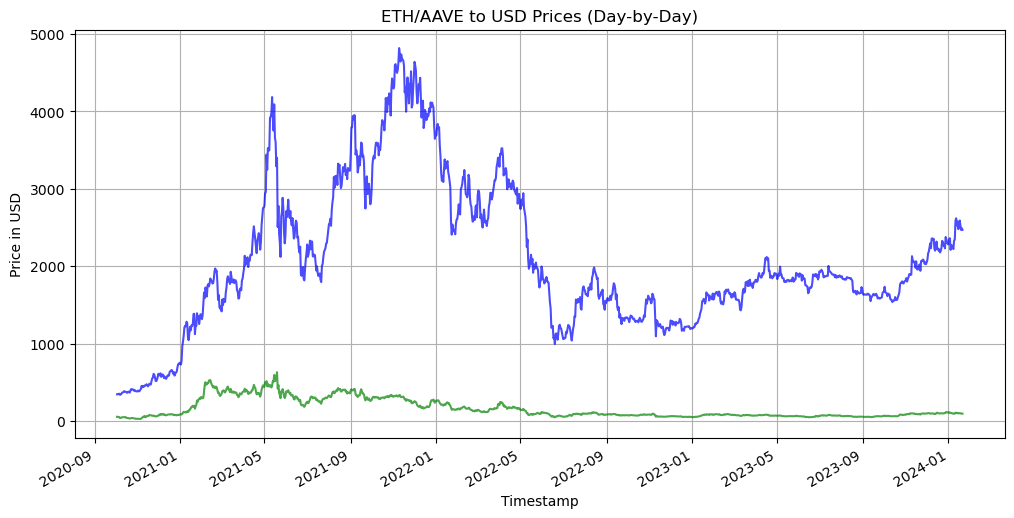

In [25]:
# Plotting prices data
plt.figure(figsize=(12, 6))
plt.plot(df_prices_usd['timestamp'], df_prices_usd['price_eth'], linestyle='-', color='blue', alpha = 0.7, label='ETH Price')
plt.plot(df_prices_usd['timestamp'], df_prices_usd['price_aave'], linestyle='-', color='green', alpha=0.7, label='AAVE Price')

plt.title('ETH/AAVE to USD Prices (Day-by-Day)')
plt.xlabel('Timestamp')
plt.ylabel('Price in USD')

# Formatting the date on the x-axis for better readability
plt.gcf().autofmt_xdate() 

plt.grid(True)
plt.show()

In [26]:
#save result
df_prices_usd.to_csv('df_prices_usd.csv')

## Data Analysis

### Internal transactions

In [27]:
#read the data
df_internal = pd.read_csv('internal_transactions.csv', index_col = 'Unnamed: 0')
df_internal.head()

,blockNumber,timeStamp,hash,from,to,value,contractAddress,input,type,gas,gasUsed,traceId,isError,errCode
0,8961759,2019-11-19 09:52:25,0x1c035b825cae5081438297b08b3f3d0afa924010061e...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,9200.0,NaN,NaN,call,2300,0.0,0,0,NaN
1,8961788,2019-11-19 10:00:22,0xe4acf4b6365ebb219dcc4fd4f9a2a85c3203fb5b38a9...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,5000.0,NaN,NaN,call,2300,0.0,0,0,NaN
2,8969426,2019-11-20 16:39:30,0x57524d0348aa596f4fda1a8638679125e34f0d5c269f...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,5267.0,NaN,NaN,call,2300,0.0,0,0,NaN
3,8981095,2019-11-22 15:15:40,0x61cc082f227d7a400b60623a4f4d69f18764039b84fd...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.0,NaN,NaN,call,2300,0.0,0,0,NaN
4,9019738,2019-11-29 06:37:41,0x19c3d81e366c2230760cfe32292944d9f4a2541a94b2...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,800.0,NaN,NaN,call,2300,0.0,0,0,NaN


In [28]:
# check if there are any unsuccessfull transactions that should be removed from the df
len(df_internal[(df_internal['contract_execution_status'] != 'successful') | (df_internal['transaction_receipt_status'] != 'successful') | (df_internal['isError'] != 0)])

0

In [29]:
#get values
df_internal.nunique()

blockNumber        136
timeStamp          136
hash               136
from                10
to                   1
value               87
contractAddress      0
input                0
type                 1
gas                267
gasUsed              1
traceId             14
isError              1
errCode              0
dtype: int64

**gasUsed Always 0:**

* Internal transactions don't independently use gas. They are part of larger transactions that consume gas. The gas used is recorded in the original, external transaction, not in these internal ones. That's why gasUsed is often 0 for internal transactions.

**type Equals 'call':**

* 'call' means these are results of smart contract functions being executed. They don't create new transactions on the blockchain but are operations within existing transactions.
* Internal transactions are sub-activities within larger transactions. They don't independently use gas or create new blockchain records; they're part of existing contract executions.

In [30]:
#drop columns
df_internal = df_internal.drop(columns=['contractAddress', 'input', 'errCode',
                                        'contract_execution_status', 'transaction_receipt_status',
                                        'gasUsed', 'type', 'isError'])

In [31]:
#let's check if there are any repeated rtransactions
hash_counts = df_internal['hash'].value_counts().sort_values(ascending=False)
hash_counts

0xbfdff11a1e67f879b00d47b40d139f2154fc5d77eacd3ff48af86e2c4804f6fe    46
0x84b3d2f20290edc0556dbc708a9cb06587b8b76dff654fef86e6567d524f70a3    34
0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8e65371b75d5c6f0c5f0b    29
0x90693d4f7edcd1839a6b1dc0e152c673827253d0c1cb803e7e530d2fb52c54be    27
0xcfe0f0a375dd2c63286c2c73e1911dbec88ff5382318c05c212532052b3e9c80    19
                                                                      ..
0x21d615612f0bc5ed8bf2f3d98040829281d743bfe2ddee90d3278d5ec4edfa7f     1
0xebfee3c2506fcd85045de00bb5ca3249a41fc04b64f7d75c18387a9e367f30a7     1
0x912da3b40f469716a02fc7d793dcd7b883f634de963dfcadc8123be3b34c48ec     1
0xb65eae6d22af1343ec11e3e04cc91815ea9219fd43b378baa6dcdf99c6821d8c     1
0x284e6481cbd06e71daf4a6eb24379bcca8f61d57cd8c039a3fb20374e152701e     1
Name: hash, Length: 136, dtype: int64

In [32]:
#Select only those rows where the 'hash' value is used in more than one row
hash_counts = df_internal['hash'].value_counts()
hashes_more_than_once = hash_counts[hash_counts > 1].index
df_filtered = df_internal[df_internal['hash'].isin(hashes_more_than_once)]

#Print unique traceId found in df_internal
unique_trace_ids = df_filtered.groupby('hash')['traceId'].unique()

unique_trace_ids

hash
0x13378f3281e903ddffeb5140cfd5df50d01d39d9a9d8b55a383acfa1bde8e7b0    [0_1_1]
0x193d0257cbdb98a135b84f0937668fbb66aea97a76d9673bd7a45f86367649ca    [0_1_1]
0x1e0e8e9318c504e4ab75c9bbbe2256d4b6dcf7b46b2aee3737c342d76ab1036d    [0_1_1]
0x3f5d7a9224b19e1da8fe642b339f224a4d4f4d0fde128a9da0a379b98385bf71    [0_1_1]
0x5cd233deceed614690630898681c072ea71654b1890c4d98045f151c7921ec90    [0_1_1]
0x6bc0028454759d74e2c03dd406bc238f34d58b9ecb0d356713a209dc1915eb33    [0_1_1]
0x84b3d2f20290edc0556dbc708a9cb06587b8b76dff654fef86e6567d524f70a3    [0_1_1]
0x90693d4f7edcd1839a6b1dc0e152c673827253d0c1cb803e7e530d2fb52c54be    [0_1_1]
0xbfdff11a1e67f879b00d47b40d139f2154fc5d77eacd3ff48af86e2c4804f6fe    [0_1_1]
0xc8d145bcca7d818189ec770b2148ba72412dfedbb3e310bbc4d0b9385b5fed21    [0_1_1]
0xcfe0f0a375dd2c63286c2c73e1911dbec88ff5382318c05c212532052b3e9c80    [0_1_1]
0xe32f427cbf47ee9215ad078d6b04e78d36261502fdb7c9bb80ecf6acdfaad77d    [0_1_1]
0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8e65371b75d5c6

In [33]:
#review transaction
hash_to_check = '0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8e65371b75d5c6f0c5f0b'
df_internal[(df_internal['hash'] == hash_to_check)].sort_values(by='timeStamp')

,blockNumber,timeStamp,hash,from,to,value,gas,traceId
208,18792181,2023-12-15 14:42:11,0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8...,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.000000,977505,0_1_1
234,18792181,2023-12-15 14:42:11,0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8...,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.000000,54095,0_1_1
233,18792181,2023-12-15 14:42:11,0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8...,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.000000,78904,0_1_1
232,18792181,2023-12-15 14:42:11,0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8...,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.000000,103711,0_1_1
231,18792181,2023-12-15 14:42:11,0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8...,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.000000,128517,0_1_1
230,18792181,2023-12-15 14:42:11,0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8...,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.000000,162872,0_1_1
229,18792181,2023-12-15 14:42:11,0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8...,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.000000,208041,0_1_1
228,18792181,2023-12-15 14:42:11,0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8...,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.000000,253209,0_1_1
227,18792181,2023-12-15 14:42:11,0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8...,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.000000,298375,0_1_1
226,18792181,2023-12-15 14:42:11,0xedac0b4877e04aecb96d9703bae994ca0b80aec7a5a8...,0x889edc2edab5f40e902b864ad4d7ade8e412f9b1,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.000000,343541,0_1_1


In [34]:
len(unique_trace_ids)

13

There are 13 complex transaction that combines unstaking ETH from Lido and transferring NFTs. This means the single transaction is performing multiple actions: both unstaking (converting staked ETH back to regular ETH) and handling NFT transactions simultaneously, likely through a smart contract designed to execute these varied operations in one go.

In [35]:
#define function for plotting

def plot_data(data, kind, title, xlabel, ylabel, 
              figsize=(20, 6), color='blue', alpha=0.6, xticks_rotation=None, grid=False, xticks_reduction=None):
    ax = data.plot(kind=kind, figsize=figsize, color=color, alpha=alpha)
    ax.grid(axis='y', alpha=0.75)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14, fontweight='bold')
    if xticks_rotation is not None:
        plt.xticks(rotation=xticks_rotation)
    if xticks_reduction is not None:
        for index, label in enumerate(ax.xaxis.get_ticklabels()):
            if index % xticks_reduction != 0:
                label.set_visible(False)
    plt.tight_layout()
    plt.show()

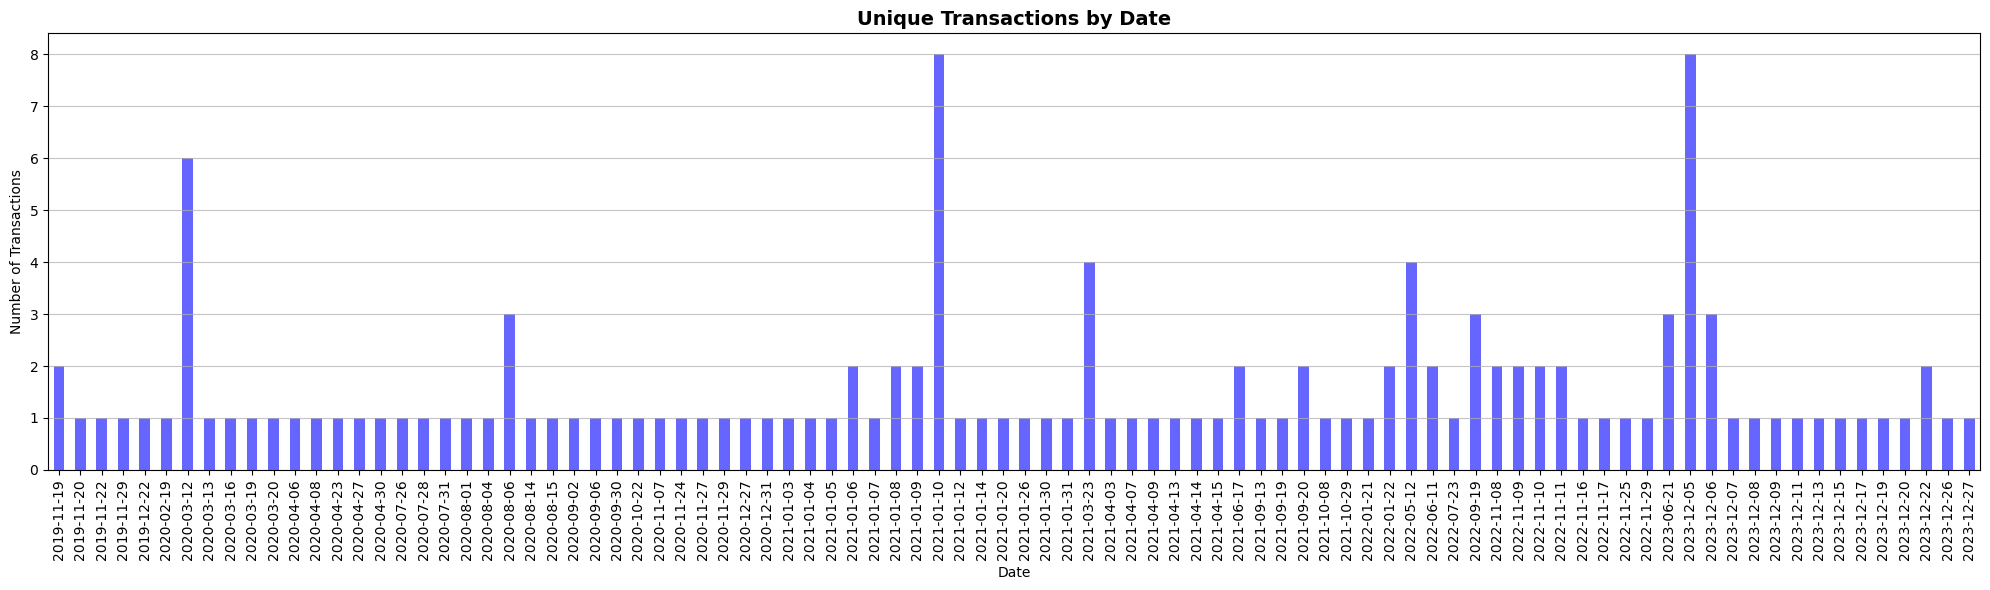

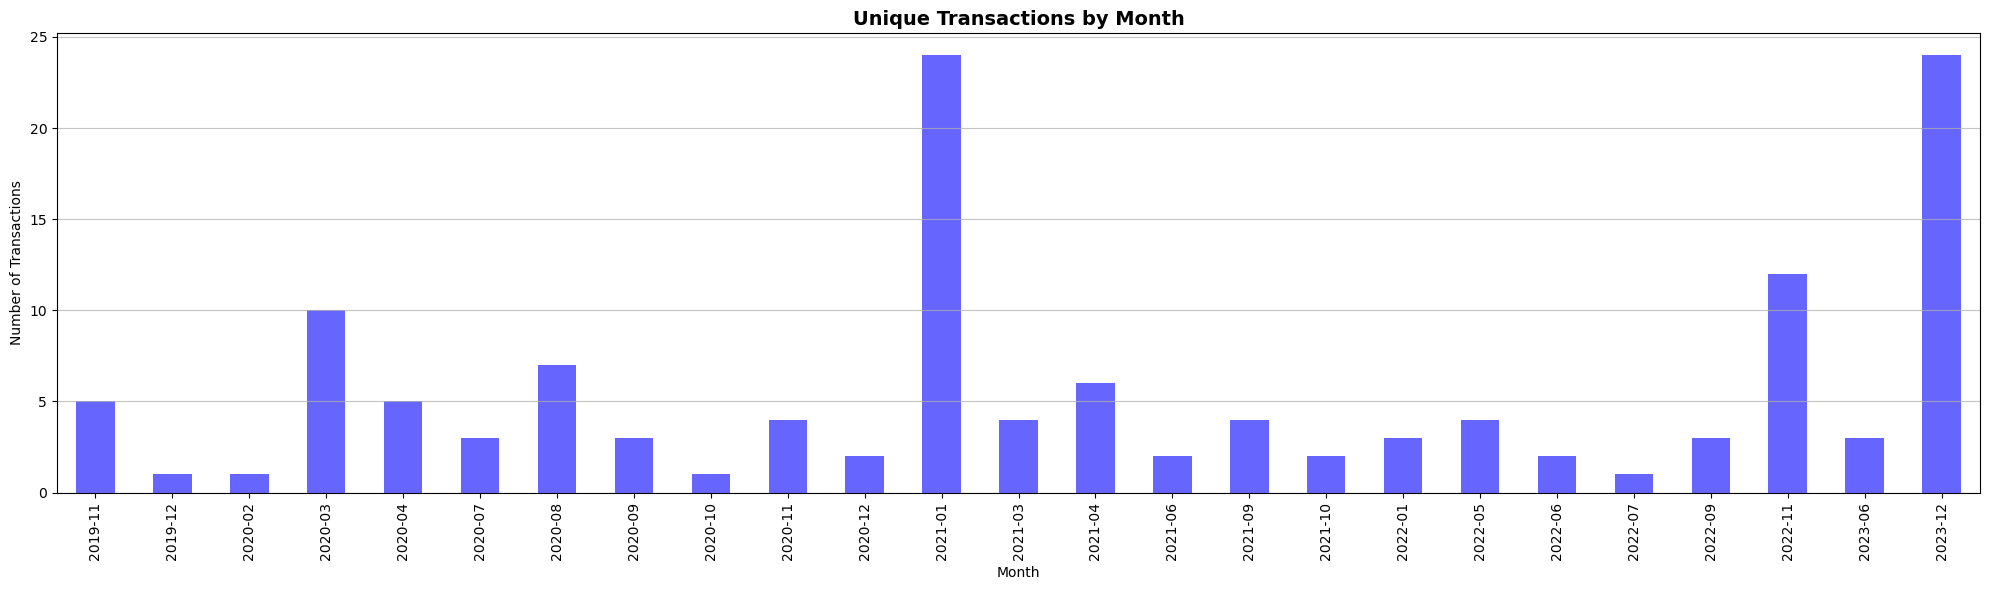

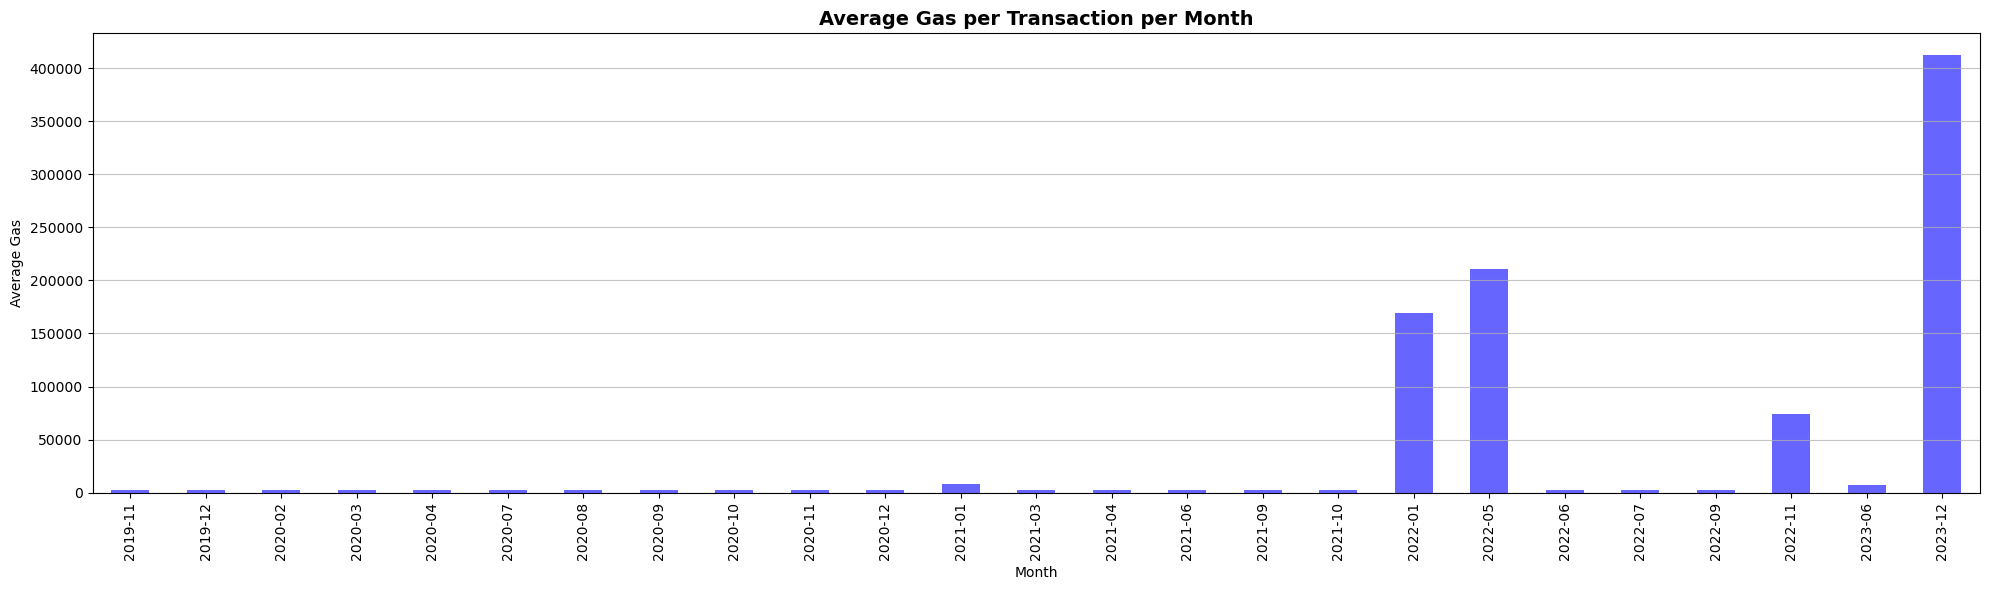

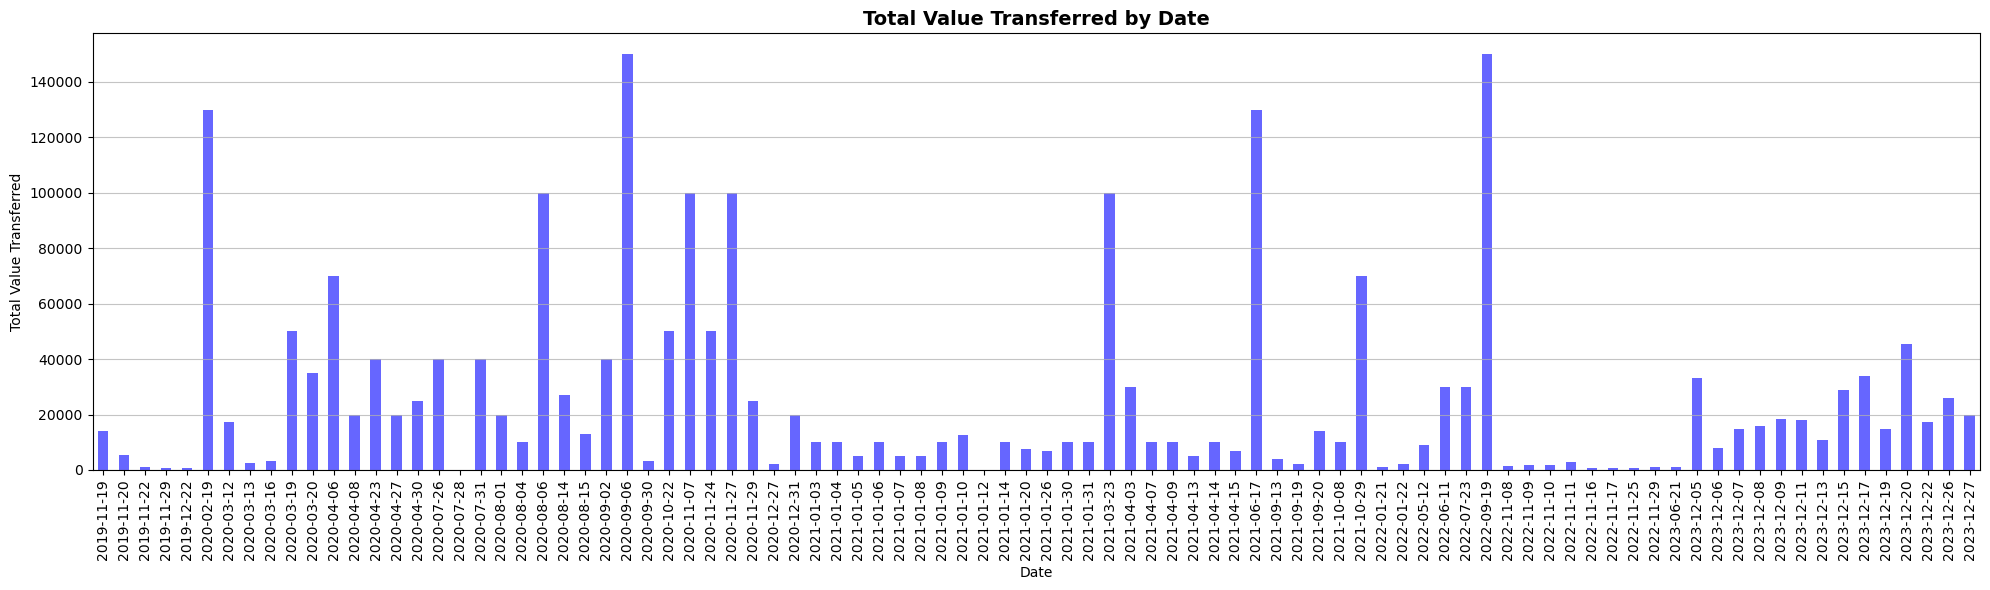

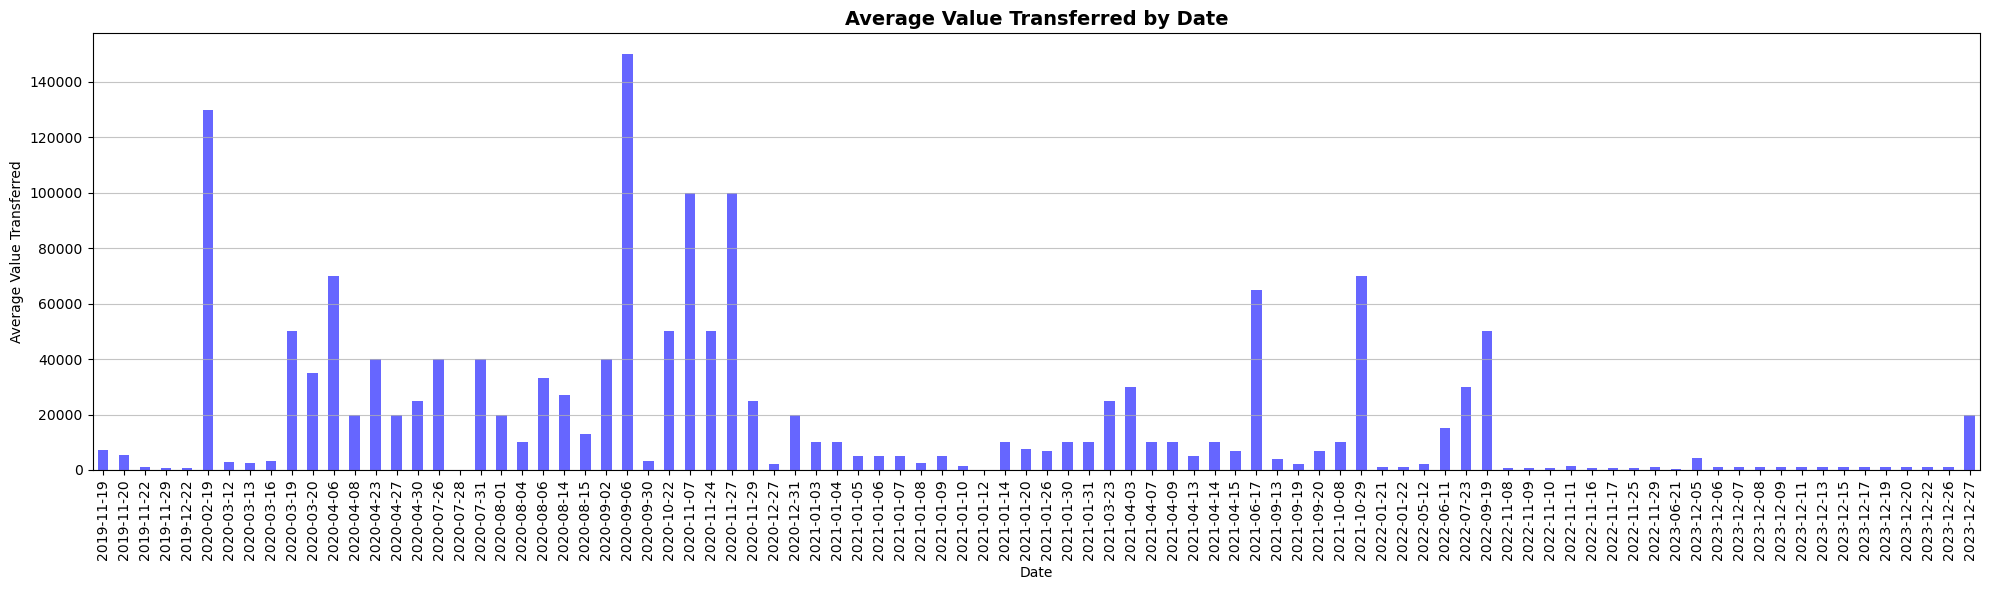

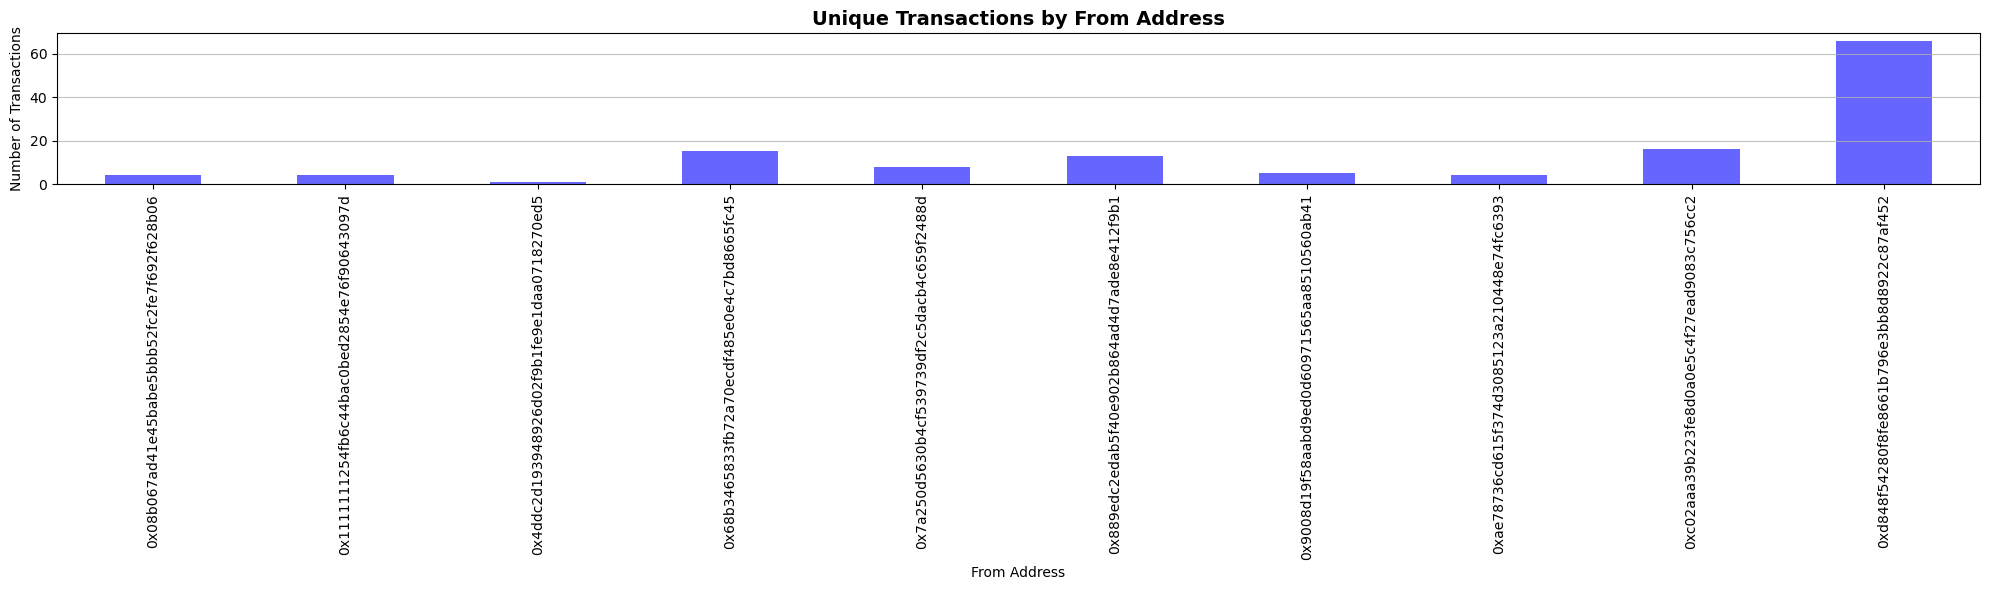

In [36]:
# Convert timeStamp to datetime and extract date and month
df_internal['timeStamp'] = pd.to_datetime(df_internal['timeStamp'])
df_internal['date'] = df_internal['timeStamp'].dt.date
df_internal['month'] = df_internal['timeStamp'].dt.to_period('M')

# 1. Number of unique transactions by date/month
transactions_by_date = df_internal.groupby('date').nunique()['hash']
transactions_by_month = df_internal.groupby('month').nunique()['hash']

# 2. Average gas paid per transaction, and per transaction per month
df_internal['gas'] = pd.to_numeric(df_internal['gas'])
avg_gas_per_transaction = df_internal.groupby('hash')['gas'].mean()
avg_gas_per_transaction_per_month = df_internal.groupby('month')['gas'].mean()

# 3. Sum and average value transferred via internal transactions
df_internal['value'] = pd.to_numeric(df_internal['value'])
total_value_transferred = df_internal['value'].sum()
average_value_transferred = df_internal['value'].mean()

# 4. Number of unique transactions by "from"
transactions_by_from = df_internal.groupby('from').nunique()['hash']


# unique transactions by date
plot_data(transactions_by_date, 'bar', 'Unique Transactions by Date', 'Date', 'Number of Transactions')

# unique transactions by month
plot_data(transactions_by_month, 'bar', 'Unique Transactions by Month', 'Month', 'Number of Transactions')

# average gas per transaction per month
plot_data(avg_gas_per_transaction_per_month, 'bar', 'Average Gas per Transaction per Month', 'Month', 'Average Gas')

# total value transferred by date
plot_data(df_internal.groupby('date')['value'].sum(), 'bar', 'Total Value Transferred by Date', 'Date', 'Total Value Transferred')

# average value transferred by date
plot_data(df_internal.groupby('date')['value'].mean(), 'bar', 'Average Value Transferred by Date', 'Date', 'Average Value Transferred')

# unique transactions by from address
plot_data(transactions_by_from, 'bar', 'Unique Transactions by From Address', 'From Address', 'Number of Transactions')

In analyzing the internal transaction spread, no specific patterns emerge, though several periods of peak activity are notable: January 2022, May 2022, November 2022, and December 2023. Moreover, there's a significant period with minimal activity, particularly when compared to 2021. In both 2022 and 2023, active months are relatively few. This pattern could be correlated with overall market conditions. Regarding the total value transferred, it appears that while the average value per transaction decreased from 2022, the total value remained consistent. This indicates an increase in the number of transactions, albeit with smaller individual transfer values. It's also observed that certain contracts or addresses exhibit higher than average activity, which warrants further investigation. Notably, the increased activity in December 2023 might be linked to the market's response to the anticipated Ethereum upgrades and the consequent shift in staking strategies.

### Normal transactions

In [37]:
#read the data
df_normal = pd.read_csv('normal_transactions.csv', index_col = 'Unnamed: 0')
df_normal.head()

,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations,methodId,functionName
0,8961000,2019-11-19 06:49:41,0x1956d7a97e04141c75af0900e30e9fa0a813081141fb...,1495,0xe85f15f7b940efb0ab189b7486880ce7e9842b50b517...,202,0x1c11ba15939e1c16ec7ca1678df6160ea2063bc5,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1.0,21000,10.0,0,1,0x,NaN,7282177,0.000021,10097266,0x,NaN
1,8961008,2019-11-19 06:51:02,0x63128cd3e4d74c6f08db5687a49863eb2aa83d2416f6...,1496,0x7cb1d66310a66aad0ed0a5a418208582b47ae92b5ad6...,69,0x1c11ba15939e1c16ec7ca1678df6160ea2063bc5,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.0,21000,10.0,0,1,0x,NaN,2750425,0.000021,10097258,0x,NaN
2,8961051,2019-11-19 06:59:40,0x8cbd80175791f801a14076683f12c4cc9f2eef790a14...,0,0x3a3f0a68506bf93ece334aa49385c7c57406a987cb72...,171,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,0x4678f0a6958e4d2bc4f1baf7bc52e8f3564f3fe4,0.0,914630,10.0,0,1,0x8e1a55fc,NaN,9470522,0.000590,10097215,0x8e1a55fc,build()
3,8961066,2019-11-19 07:04:39,0x4d4c3827b2d91039f326ec6205a7f17067e378bb3319...,1,0xe49b5776b46f4b2acc401200f9cebd23391579ed5696...,117,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,0xd848f54280f8fe8661b796e3bb8d8922c87af452,1000.0,1031515,10.0,0,1,0x1cff79cd00000000000000000000000082ecd135dce6...,NaN,5751866,0.000594,10097200,0x1cff79cd,"execute(address _target, bytes _data)"
4,8961076,2019-11-19 07:07:40,0x60ab9b59a03330fbfc7ab0725d719a38f3014e580280...,2,0xb05dfec2a84c246455e5ad52b278d0eb7a468a5edc45...,110,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,0x6b175474e89094c44da98b954eedeac495271d0f,0.0,61451,12.5,0,1,0x095ea7b300000000000000000000000039755357759c...,NaN,4154186,0.000047,10097190,0x095ea7b3,"approve(address _spender, uint256 _value)"


In [39]:
#check if there are any problematic transactions that should be excluded
len(df_normal[(df_normal['contract_execution_status'] != 'successful') | (df_normal['transaction_receipt_status'] != 'successful') | (df_normal['isError'] != 0)])

0

In [40]:
#check also transaction receipt
len(df_normal[(df_normal['txreceipt_status'] != 1)])

21

In [41]:
#Let's exclude these rows from the df
df_normal = df_normal[df_normal['txreceipt_status'] == 1].reset_index(drop = True)

In [42]:
#check values
df_normal.nunique()

blockNumber          1649
timeStamp            1649
hash                 1678
nonce                1646
blockHash            1649
transactionIndex      293
from                   21
to                     70
value                  95
gas                   618
gasPrice              630
isError                 1
txreceipt_status        1
input                1058
contractAddress         0
cumulativeGasUsed    1677
gasUsed               712
confirmations        1649
methodId               55
functionName           52
dtype: int64

In [43]:
#drop useless columns
df_normal = df_normal.drop(columns=['contract_execution_status', 'transaction_receipt_status', 'type',
                                    'isError', 'gasUsed',  'contractAddress', 'input', 'nonce', 'transactionIndex'])

In [44]:
#function to fix function names
def remove_parentheses(text):
    if isinstance(text, str):
        start = text.find('(')
        return text[:start] if start != -1 else text
    else:
        return text 

In [45]:
# Apply the function to the 'functionName' column
df_normal['functionNameUpdated'] = df_normal['functionName'].apply(remove_parentheses)
df_normal.head()

,blockNumber,timeStamp,hash,blockHash,from,to,value,gas,gasPrice,txreceipt_status,cumulativeGasUsed,confirmations,methodId,functionName,functionNameUpdated
0,8961000,2019-11-19 06:49:41,0x1956d7a97e04141c75af0900e30e9fa0a813081141fb...,0xe85f15f7b940efb0ab189b7486880ce7e9842b50b517...,0x1c11ba15939e1c16ec7ca1678df6160ea2063bc5,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1.0,21000,10.0,1,7282177,10097266,0x,NaN,NaN
1,8961008,2019-11-19 06:51:02,0x63128cd3e4d74c6f08db5687a49863eb2aa83d2416f6...,0x7cb1d66310a66aad0ed0a5a418208582b47ae92b5ad6...,0x1c11ba15939e1c16ec7ca1678df6160ea2063bc5,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,1000.0,21000,10.0,1,2750425,10097258,0x,NaN,NaN
2,8961051,2019-11-19 06:59:40,0x8cbd80175791f801a14076683f12c4cc9f2eef790a14...,0x3a3f0a68506bf93ece334aa49385c7c57406a987cb72...,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,0x4678f0a6958e4d2bc4f1baf7bc52e8f3564f3fe4,0.0,914630,10.0,1,9470522,10097215,0x8e1a55fc,build(),build
3,8961066,2019-11-19 07:04:39,0x4d4c3827b2d91039f326ec6205a7f17067e378bb3319...,0xe49b5776b46f4b2acc401200f9cebd23391579ed5696...,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,0xd848f54280f8fe8661b796e3bb8d8922c87af452,1000.0,1031515,10.0,1,5751866,10097200,0x1cff79cd,"execute(address _target, bytes _data)",execute
4,8961076,2019-11-19 07:07:40,0x60ab9b59a03330fbfc7ab0725d719a38f3014e580280...,0xb05dfec2a84c246455e5ad52b278d0eb7a468a5edc45...,0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4,0x6b175474e89094c44da98b954eedeac495271d0f,0.0,61451,12.5,1,4154186,10097190,0x095ea7b3,"approve(address _spender, uint256 _value)",approve


In [46]:
#Dictionaries

#functions descriptions
function_descriptions = {
    '': 'Default operation (no specific function)',
    '0x7c025200': 'Function identifier (specific to contract)',
    'approve': 'Approve a spender to use a specific amount of tokens',
    'approveLink': 'Approve a link or connection with another entity',
    'borrow': 'Borrow assets or funds',
    'build': 'Build or create a new contract or entity',
    'burn': 'Burn or permanently destroy tokens',
    'cancel': 'Cancel an operation or transaction',
    'claimComp': 'Claim compensation or rewards',
    'claimRewards': 'Claim earned rewards',
    'claimWithdrawals': 'Claim withdrawals from a system or contract',
    'cooldown': 'Initiate a cooldown period for an operation',
    'deposit': 'Deposit funds or assets',
    'enterMarkets': 'Enter into financial or trading markets',
    'exactInput': 'Specify exact input for a transaction',
    'exchange': 'Exchange one asset or currency for another',
    'exchange_multiple': 'Perform multiple exchanges in a single transaction',
    'exchange_underlying': 'Exchange underlying assets',
    'execTransaction': 'Execute a specified transaction',
    'execute': 'Execute a specified command or operation',
    'exitMarket': 'Exit a financial or trading market',
    'free': 'Free or release assets',
    'freeAll': 'Release all held or locked assets',
    'initiateLink': 'Initiate a link or connection',
    'lock': 'Lock assets or functionality',
    'migrateFromLegacyReputationToken': 'Migrate from a legacy token system',
    'mint': 'Create or mint new tokens',
    'multicall': 'Execute multiple calls or transactions in one',
    'offer': 'Make an offer, typically in trading',
    'redeem': 'Redeem tokens for underlying assets',
    'redeemUnderlying': 'Redeem tokens for the underlying value',
    'repayBorrow': 'Repay a borrowed amount',
    'requestWithdrawalsWstETHWithPermit': 'Request withdrawals with permission',
    'submit': 'Submit data or a transaction',
    'swap': 'Swap one asset or token for another',
    'swapDaiToSai': 'Swap DAI tokens for SAI tokens',
    'swapETHForExactTokens': 'Swap ETH for a specific amount of tokens',
    'swapExactETHForTokens': 'Swap an exact amount of ETH for tokens',
    'swapExactTokensForTokens': 'Swap an exact amount of tokens for other tokens',
    'transfer': 'Transfer assets or tokens to another address',
    'uniswapV3Swap': 'Perform a swap operation on Uniswap V3',
    'vote': 'Cast a vote or participate in a poll',
    'withdraw': 'Withdraw funds or assets',
    'wrap': 'Wrap assets, typically for compatibility or use in DeFi'
}

tokens = {
    '0x6b175474e89094c44da98b954eedeac495271d0f': 'DAI',
    '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': 'USDC',
    '0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359': 'SAI',
    '0xe41d2489571d322189246dafa5ebde1f4699f498': 'ZRX',
    '0xc00e94cb662c3520282e6f5717214004a7f26888': 'COMP',
    '0xdac17f958d2ee523a2206206994597c13d831ec7': 'USDT',
    '0x960b236a07cf122663c4303350609a66a7b288c0': 'ANT',
    '0x408e41876cccdc0f92210600ef50372656052a38': 'REN',
    '0xd26114cd6ee289accf82350c8d8487fedb8a0c07': 'OMG',
    '0xa74476443119a942de498590fe1f2454d7d4ac0d': 'GNT',
    '0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2': 'MKR',
    '0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9': 'AAVE'
}

#decimal for tokens
token_decimals = {
    'DAI': 18,  
    'USDC': 6, 
    'SAI': 18,   
    'ZRX': 18,  
    'COMP': 18, 
    'USDT': 6,  
    'ANT': 18,   
    'REN': 18, 
    'OMG': 18, 
    'GNT': 18, 
    'MKR': 18, 
    'AAVE': 18,
    'ETH': 18
}

In [47]:
# Add function description
df_normal['functionDescription'] = df_normal['functionNameUpdated'].map(function_descriptions)

# Add token name
df_normal['tokenName'] = df_normal.apply(lambda row: tokens[row['to']] if row['to'] in tokens else '', axis=1)

In [48]:
#let's check if there are any repeated rtransactions
hash_counts = df_normal['hash'].value_counts().sort_values(ascending=False)
hash_counts

0x1956d7a97e04141c75af0900e30e9fa0a813081141fbeac74991554baa5c8cbc    1
0x4fe3a16f49c236fb9f09961e25e9dcd37ae3c4838156826d35b7e5fdeac8357c    1
0x4d4c3827b2d91039f326ec6205a7f17067e378bb3319f3dd88ba906203a00fb5    1
0x60ab9b59a03330fbfc7ab0725d719a38f3014e5802803bf447f3f1e510e35f68    1
0x31d07d90af71a8434025a4336f0bf63c84ef363f6d6f87d82745a5114746e47e    1
                                                                     ..
0x6718ef4b3629ff15e75a8c4c651f9fc1f3b05c16c0f5c8ddd6f469fdc92a7d44    1
0x956a9c0ddfcb4d08a68288cf5b1203e8f2b86998872a4ec094d862c49cb01cc2    1
0xa295989d6440f102fc826177455e544224372fbee293531424a5e5ff669b7416    1
0x444a2c3043f68fa424f7a942e7b1b3b6843ce44b01f9005ba1f8681f433c4f32    1
0x9acfd7a203ec2842d4fbef65f3d5d8aba2ec5cdb109c9cd6d4605a4c21b692ce    1
Name: hash, Length: 1678, dtype: int64

There are no duplicated values

In [50]:
#get unique values for transfer transactions
transfer_rows = df_normal[df_normal['methodId'] == '0xa9059cbb']
unique_to_addresses = transfer_rows['to'].unique()

In [51]:
unique_to_addresses

array(['0x6b175474e89094c44da98b954eedeac495271d0f',
       '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
       '0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359',
       '0xe41d2489571d322189246dafa5ebde1f4699f498',
       '0xc00e94cb662c3520282e6f5717214004a7f26888',
       '0xdac17f958d2ee523a2206206994597c13d831ec7',
       '0x960b236a07cf122663c4303350609a66a7b288c0',
       '0x408e41876cccdc0f92210600ef50372656052a38',
       '0xd26114cd6ee289accf82350c8d8487fedb8a0c07',
       '0xa74476443119a942de498590fe1f2454d7d4ac0d',
       '0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2',
       '0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9'], dtype=object)

In [52]:
print(f"There were interactions with {len(unique_to_addresses)} different addresses")

There were interactions with 12 different addresses


In [53]:
# Function to get contract creators for the tokens
def get_contract_creator(token_address, api_key):
    url = f"https://api.etherscan.io/api?module=account&action=txlist&address={token_address}&sort=asc&apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        transactions = response.json()['result']
        if transactions:
            return transactions[0]['from']
    return ''

In [54]:
contract_creators = {address: get_contract_creator(address, ETHERSCAN_API_KEY) for address in tokens.keys()}
# Create a DataFrame for contract creators
df_creators = pd.DataFrame(list(contract_creators.items()), columns=['ContractAddress', 'DeployerAddress'])
df_creators

,ContractAddress,DeployerAddress
0,0x6b175474e89094c44da98b954eedeac495271d0f,0x00ecd4635c80d47a8b5ffbfd2eb794e0ce6a8689
1,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x95ba4cf87d6723ad9c0db21737d862be80e93911
2,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0x009be56dd91808b2ab35959a65245732c73fe871
3,0xe41d2489571d322189246dafa5ebde1f4699f498,0xa3b2d1087bcebe59d188a23f75620612d967df72
4,0xc00e94cb662c3520282e6f5717214004a7f26888,0x1449e0687810bddd356ae6dd87789244a46d9adb
5,0xdac17f958d2ee523a2206206994597c13d831ec7,0x36928500bc1dcd7af6a2b4008875cc336b927d57
6,0x960b236a07cf122663c4303350609a66a7b288c0,0x7f478213dd4a4df6016922aa47b860f0bdf50075
7,0x408e41876cccdc0f92210600ef50372656052a38,0x9b1b265e548283430e6ae4721842c448f4bed559
8,0xd26114cd6ee289accf82350c8d8487fedb8a0c07,0x140427a7d27144a4cda83bd6b9052a63b0c5b589
9,0xa74476443119a942de498590fe1f2454d7d4ac0d,0x42c8fcbc73d625f1d258a32915b6a573095de93d


Every address was manually checked via Ethersan since this API endpoint is only for pro sunbscription

### General info about account

Get summary about account before we continue with the normal transactions 

In [55]:
#get information about account - function
def get_account_info(address, api_key):
    url_balance = f"https://api.etherscan.io/api?module=account&action=balance&address={address}&apikey={api_key}"
    url_txlist = f"https://api.etherscan.io/api?module=account&action=txlist&address={address}&startblock=0&endblock=99999999&page=1&offset=1&sort=asc&apikey={api_key}"

    account_info = {}

    # Fetch the account balance
    response_balance = requests.get(url_balance)
    if response_balance.status_code == 200:
        data_balance = response_balance.json()
        account_info['balance'] = int(data_balance['result']) / 10**18  # Convert Wei to Ether

    # Get the first transaction
    response_txlist = requests.get(url_txlist)
    if response_txlist.status_code == 200:
        data_txlist = response_txlist.json()
        transactions = data_txlist['result']
        if transactions:
            account_info['creation_date'] = pd.to_datetime(transactions[0]['timeStamp'], unit='s')
            account_info['first_transaction_hash'] = transactions[0]['hash']
        else:
            account_info['creation_date'] = 'No transactions found'
            account_info['first_transaction_hash'] = 'No transactions found'

    return account_info

In [56]:
# output
account_info = get_account_info(address, ETHERSCAN_API_KEY)
print('Balance:', account_info['balance'])
print('Creation Date:', account_info['creation_date'])
print('First Transacrion Hash:', account_info['first_transaction_hash'])

Balance: 116427.50872165187
Creation Date: 2019-11-19 06:49:41
First Transacrion Hash: 0x1956d7a97e04141c75af0900e30e9fa0a813081141fbeac74991554baa5c8cbc


####  Get balances for Contracts

We have identified that this Ethereum address has engaged with various protocols and contracts. To gain a deeper insight into its activities, we will investigate whether the interactions involved a range of tokens, rather than being limited to just Ethereum (ETH).

In [57]:
#function to get balances from different contracts
def get_token_balance(eth_address, contract_address, api_key):
    url = f"https://api.etherscan.io/api?module=account&action=tokenbalance&contractaddress={contract_address}&address={address}&tag=latest&apikey={api_key}"
    response = requests.get(url)
    data = response.json()
    return data['result']

In [58]:
# List of contract addresses to check
contract_addresses = df_creators['ContractAddress'].to_list()

token_balances = {}

# Get balances for each token
for contract_address in contract_addresses:
    balance = get_token_balance(address, contract_address, ETHERSCAN_API_KEY)
    token_balances[contract_address] = balance

# Convert to df + add token info
df_token_balances = pd.DataFrame(list(token_balances.items()), columns=['Contract Address', 'Balance'])
df_token_balances['Token Symbol'] = df_token_balances['Contract Address'].map(tokens)
df_token_balances['decimals'] = df_token_balances['Token Symbol'].map(token_decimals)
df_token_balances.tail()

,Contract Address,Balance,Token Symbol,decimals
7,0x408e41876cccdc0f92210600ef50372656052a38,0,REN,18
8,0xd26114cd6ee289accf82350c8d8487fedb8a0c07,0,OMG,18
9,0xa74476443119a942de498590fe1f2454d7d4ac0d,0,GNT,18
10,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2,28158526772783799618975,MKR,18
11,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9,378167753275277763730,AAVE,18


In [59]:
# Add cooverted balances
df_token_balances['Balance'] = df_token_balances['Balance'].apply(Decimal)
df_token_balances['decimals'] = df_token_balances['decimals'].astype(int)

df_token_balances['Balance Converted'] = df_token_balances.apply(
    lambda row: row['Balance'] / (10 ** row['decimals']), axis=1
)
df_token_balances

,Contract Address,Balance,Token Symbol,decimals,Balance Converted
0,0x6b175474e89094c44da98b954eedeac495271d0f,0,DAI,18,0
1,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0,USDC,6,0
2,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,0,SAI,18,0
3,0xe41d2489571d322189246dafa5ebde1f4699f498,0,ZRX,18,0
4,0xc00e94cb662c3520282e6f5717214004a7f26888,0,COMP,18,0
5,0xdac17f958d2ee523a2206206994597c13d831ec7,0,USDT,6,0
6,0x960b236a07cf122663c4303350609a66a7b288c0,0,ANT,18,0
7,0x408e41876cccdc0f92210600ef50372656052a38,0,REN,18,0
8,0xd26114cd6ee289accf82350c8d8487fedb8a0c07,0,OMG,18,0
9,0xa74476443119a942de498590fe1f2454d7d4ac0d,0,GNT,18,0


In [60]:
#Add eth - since it also in use
total_balance = df_token_balances[(df_token_balances['Balance']>0)][['Token Symbol', 'Balance Converted']].reset_index(drop = True)
new_row = {'Token Symbol': 'ETH', 'Balance Converted': account_info['balance']}

new_row_df = pd.DataFrame([new_row])
total_balance = pd.concat([total_balance, new_row_df], ignore_index=True)
total_balance['USD'] = [766513.89, 37550.17, 235988663.84]

# get share of total
total = total_balance['USD'].sum()
total_balance['USD Share, %'] = round((total_balance['USD'] / total) * 100, 2)

total_balance.sort_values(by='USD', ascending = False)

,Token Symbol,Balance Converted,USD,"USD Share, %"
2,ETH,116427.508722,2.359887e+08,99.66
0,MKR,28158.526772783799618975,7.665139e+05,0.32
1,AAVE,378.16775327527776373,3.755017e+04,0.02


Almost 100% of address balance is in liquid ETH tokens

In [61]:
#save result
total_balance.to_csv('total_balance.csv')

In [64]:
#get protocols/addresses with biggest interation
from_df = df_normal['from'].to_list()
to_df = df_normal['to'].to_list()
merged_addresses = list(set(from_df + to_df))

In [66]:
if '0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4' in merged_addresses:
    merged_addresses.remove('0x7d6149ad9a573a6e2ca6ebf7d4897c1b766841b4')

address_transaction_count = {}

# Count unique transactions for each address
for address in merged_addresses:
    count = df_normal[(df_normal['to'] == address) | (df_normal['from'] == address)]['hash'].nunique()
    address_transaction_count[address] = count

# Convert the dictionary to a DataFrame for easy sorting
address_count_df = pd.DataFrame(list(address_transaction_count.items()), columns=['Address', 'UniqueTransactionCount'])

# Sort the DataFrame in descending order of unique transaction count
sorted_address_count_df = address_count_df.sort_values(by='UniqueTransactionCount', ascending=False)

print(sorted_address_count_df[(sorted_address_count_df['UniqueTransactionCount']>10)])

                                       Address  UniqueTransactionCount
69  0xd848f54280f8fe8661b796e3bb8d8922c87af452                     452
68  0xf9be8f0945acddeedaa64dfca5fe9629d0cf8e5d                     148
71  0x1c11ba15939e1c16ec7ca1678df6160ea2063bc5                     119
76  0x6b175474e89094c44da98b954eedeac495271d0f                     110
16  0x794e6e91555438afc3ccf1c5076a74f42133d08d                      70
60  0x5d3a536e4d6dbd6114cc1ead35777bab948e3643                      70
81  0x3d9819210a31b4961b30ef54be2aed79b9c9cd3b                      63
38  0x39755357759ce0d7f32dc8dc45414cca409ae24e                      52
4   0xf650c3d88d12db855b8bf7d11be6c55a4e07dcc9                      43
80  0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9                      42
70  0xdac17f958d2ee523a2206206994597c13d831ec7                      41
9   0xc00e94cb662c3520282e6f5717214004a7f26888                      38
30  0xcfeed3fbefe9eb09b37539eaa0ddd58d1e1044ca                      36
19  0x

Every address was manually checked via Ethersan since this API endpoint is only for pro sunbscription

### NFTs

In [67]:
nfts = {
    '0x889edc2edab5f40e902b864ad4d7ade8e412f9b1': 'unstETH Lido',
    '0x48a6189c582deb79a12de99e7db5dfb076484284': 'Quadrat NFT Pass'
}

In [68]:
df_nft['nftName'] = df_nft['contractAddress'].map(nfts)

# Burned tokens/NFTs (where "to" is 0x0)
burned = df_nft[df_nft['to'] == '0x0000000000000000000000000000000000000000']
burned_nfts = burned['nftName'].unique()

# Minted tokens/NFTs (where "from" is 0x0)
minted = df_nft[df_nft['from'] == '0x0000000000000000000000000000000000000000']
minted_nfts = minted['nftName'].unique()

# Current holdings (NFTs not burned)
latest_transactions = df_nft.sort_values(by='timeStamp').drop_duplicates(subset=['contractAddress', 'tokenID'], keep='last')
current_holdings = latest_transactions[~latest_transactions['to'].isin(['0x0000000000000000000000000000000000000000'])]
current_nfts = current_holdings['nftName'].unique()

# Visualization
minted_counts = minted['nftName'].value_counts()
burned_counts = burned['nftName'].value_counts()

print("Burned NFTs:", burned_nfts)
print("Minted NFTs:", minted_nfts)
print("Current NFT Holdings:", current_nfts)

Burned NFTs: ['unstETH Lido']
Minted NFTs: ['Quadrat NFT Pass' 'unstETH Lido']
Current NFT Holdings: ['Quadrat NFT Pass']


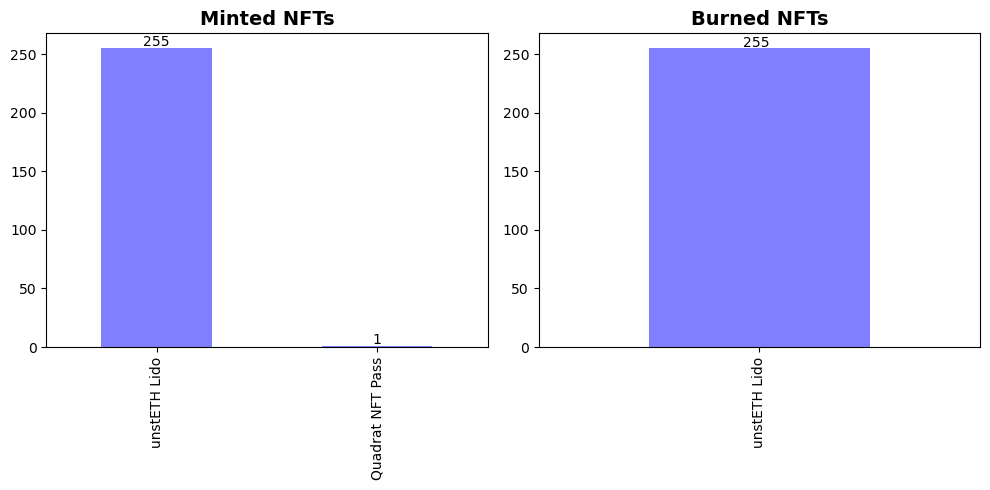

In [69]:
# Plot for Minted NFTs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
minted_bar = minted_counts.plot(kind='bar', color='blue', alpha = 0.5)
plt.title('Minted NFTs', fontsize=14, fontweight='bold')
for p in minted_bar.patches:
    minted_bar.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 4.5), textcoords='offset points')

# Plot for Burned NFTs
plt.subplot(1, 2, 2)
burned_bar = burned_counts.plot(kind='bar', color='blue', alpha = 0.5)
plt.title('Burned NFTs', fontsize=14, fontweight='bold')
for p in burned_bar.patches:
    burned_bar.annotate(str(p.get_height()), (p.get_x() * 0.15, p.get_height() * 1.005))

plt.tight_layout()
plt.show()

### Normal transactions - again

Let's check correlation between token prices and account activity

In [70]:
# Convert timestamp in df_prices_usd to datetime
df_prices_usd['timestamp'] = pd.to_datetime(df_prices_usd['timestamp']).dt.date
df_normal['timeStamp'] = pd.to_datetime(df_normal['timeStamp'])
df_normal['date'] = df_normal['timeStamp'].dt.date

# Group
transactions_per_day = df_normal.groupby('date')['hash'].nunique()
gas_sum_per_day = df_normal.groupby('date')['gas'].sum()

# Merge
merged_data = pd.DataFrame({
    'transactions_per_day': transactions_per_day,
    'gas_sum_per_day': gas_sum_per_day
}).merge(df_prices_usd, left_index=True, right_on='timestamp')

In [71]:
correlation = merged_data.corr()
print(correlation)

                      transactions_per_day  gas_sum_per_day  price_eth  \
transactions_per_day              1.000000         0.564627   0.083614   
gas_sum_per_day                   0.564627         1.000000   0.116418   
price_eth                         0.083614         0.116418   1.000000   
price_aave                        0.041807        -0.049164   0.659913   

                      price_aave  
transactions_per_day    0.041807  
gas_sum_per_day        -0.049164  
price_eth               0.659913  
price_aave              1.000000  


/var/folders/yn/q4t81jhx14b9p_14lwh_1q6w0000gn/T/ipykernel_75630/3387944129.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = merged_data.corr()


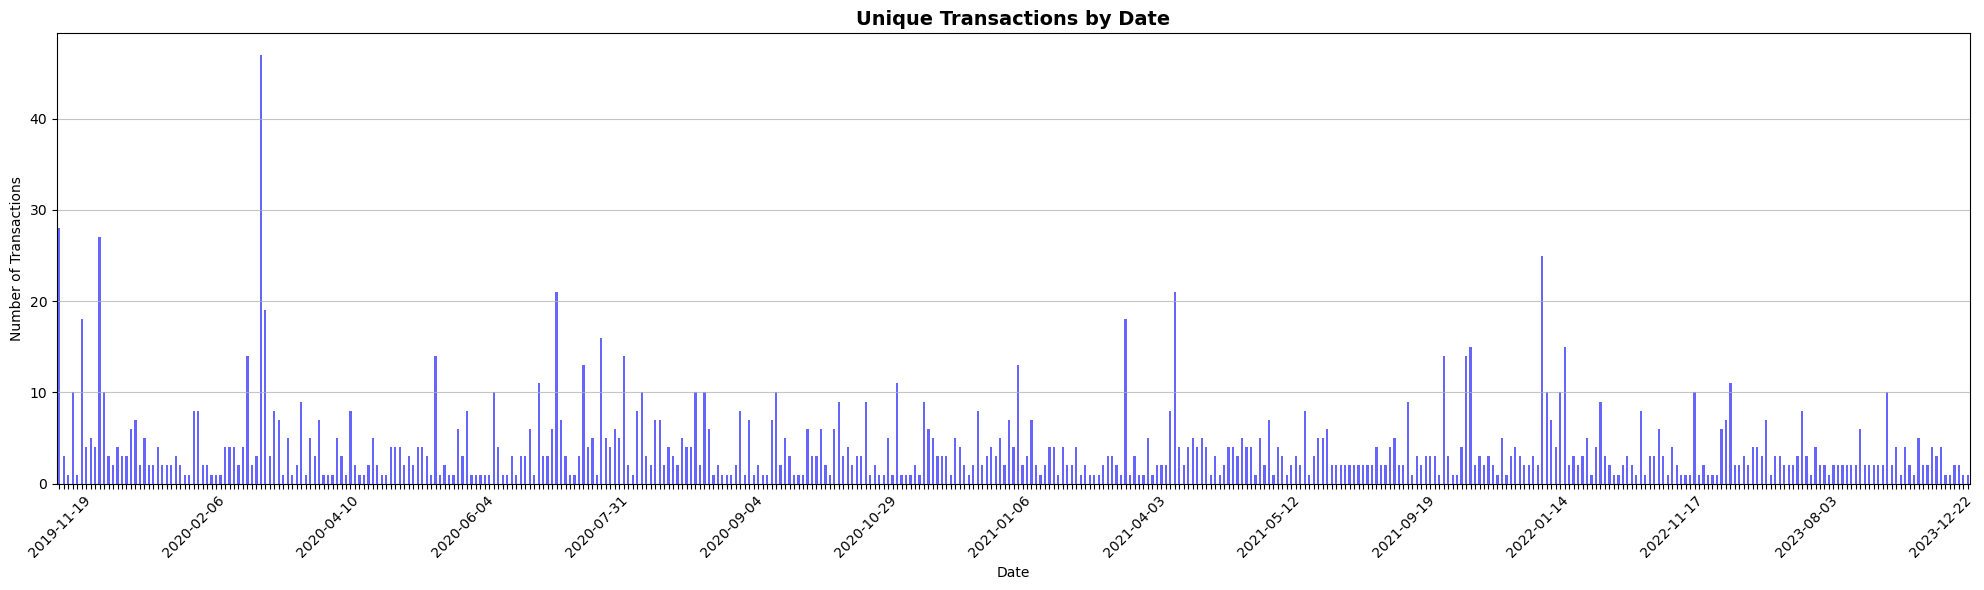

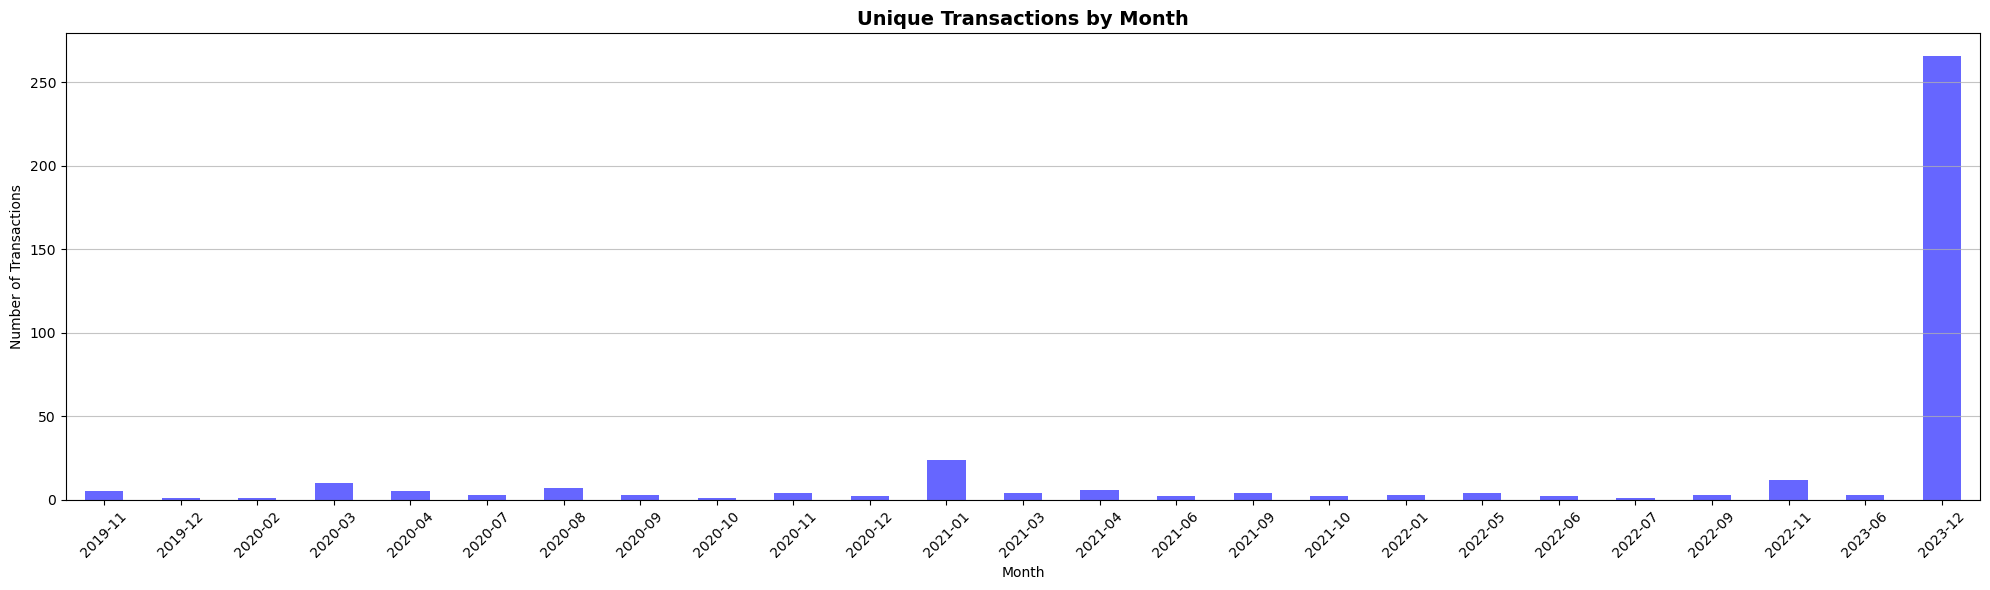

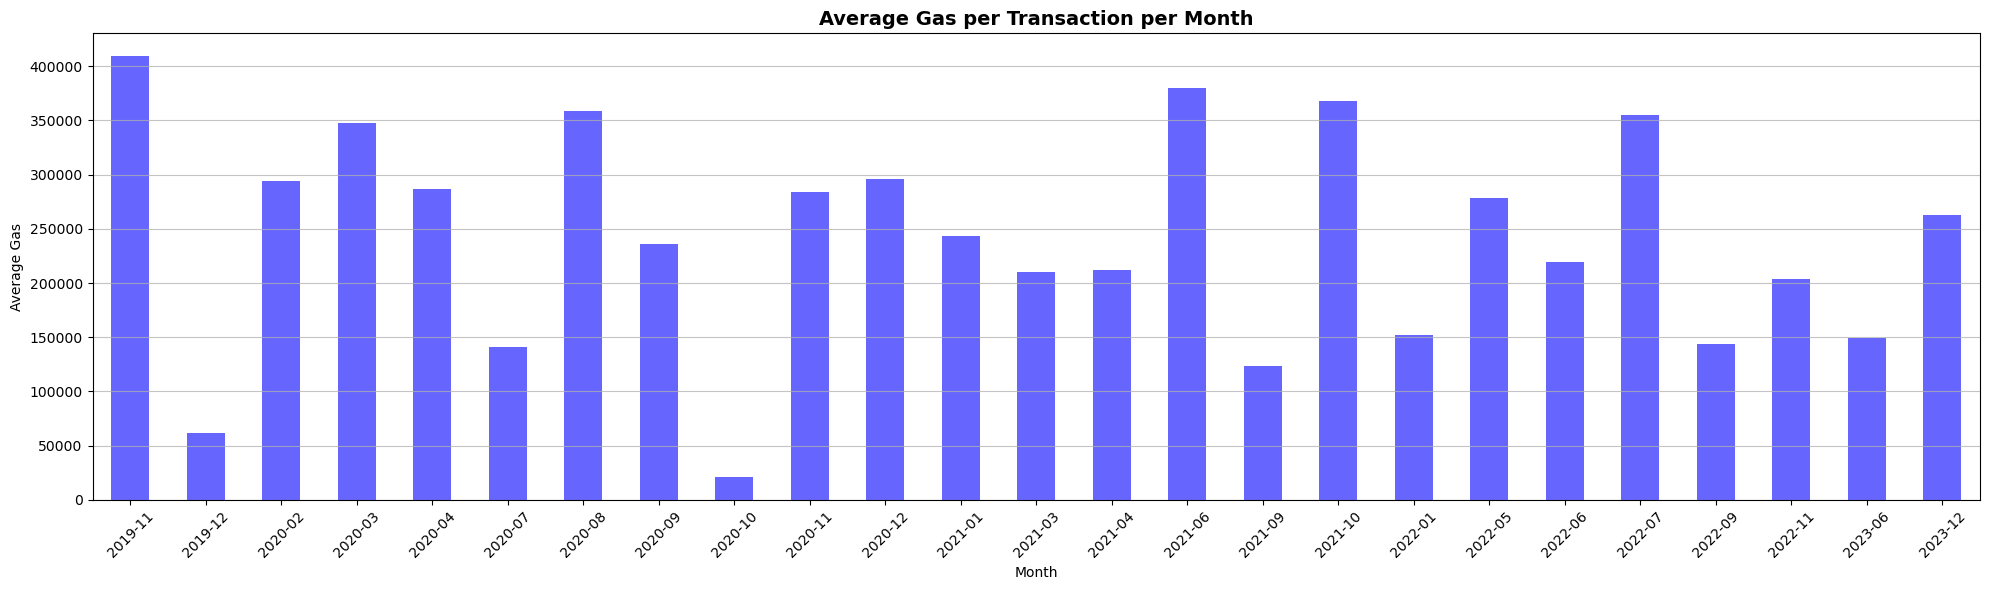

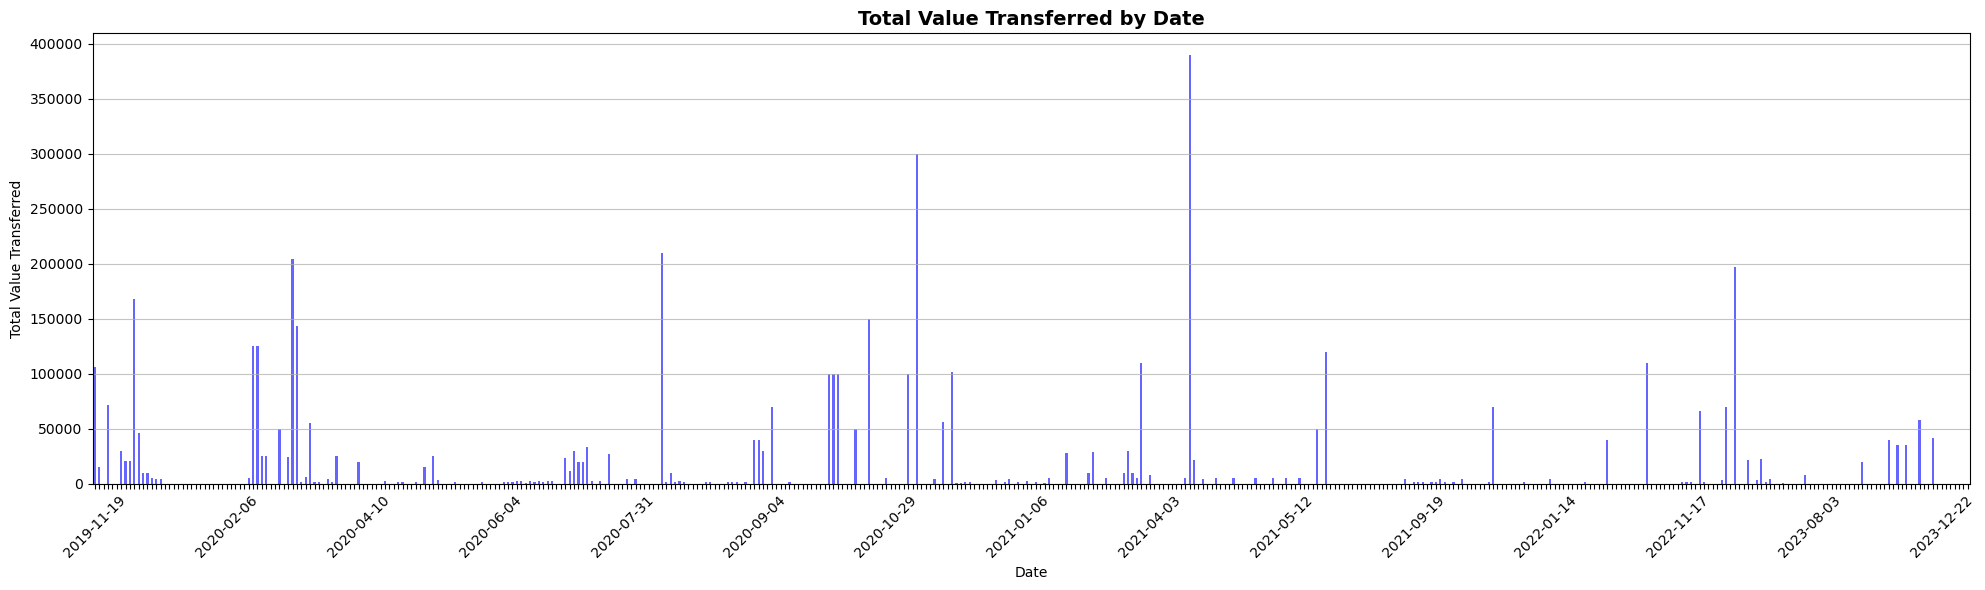

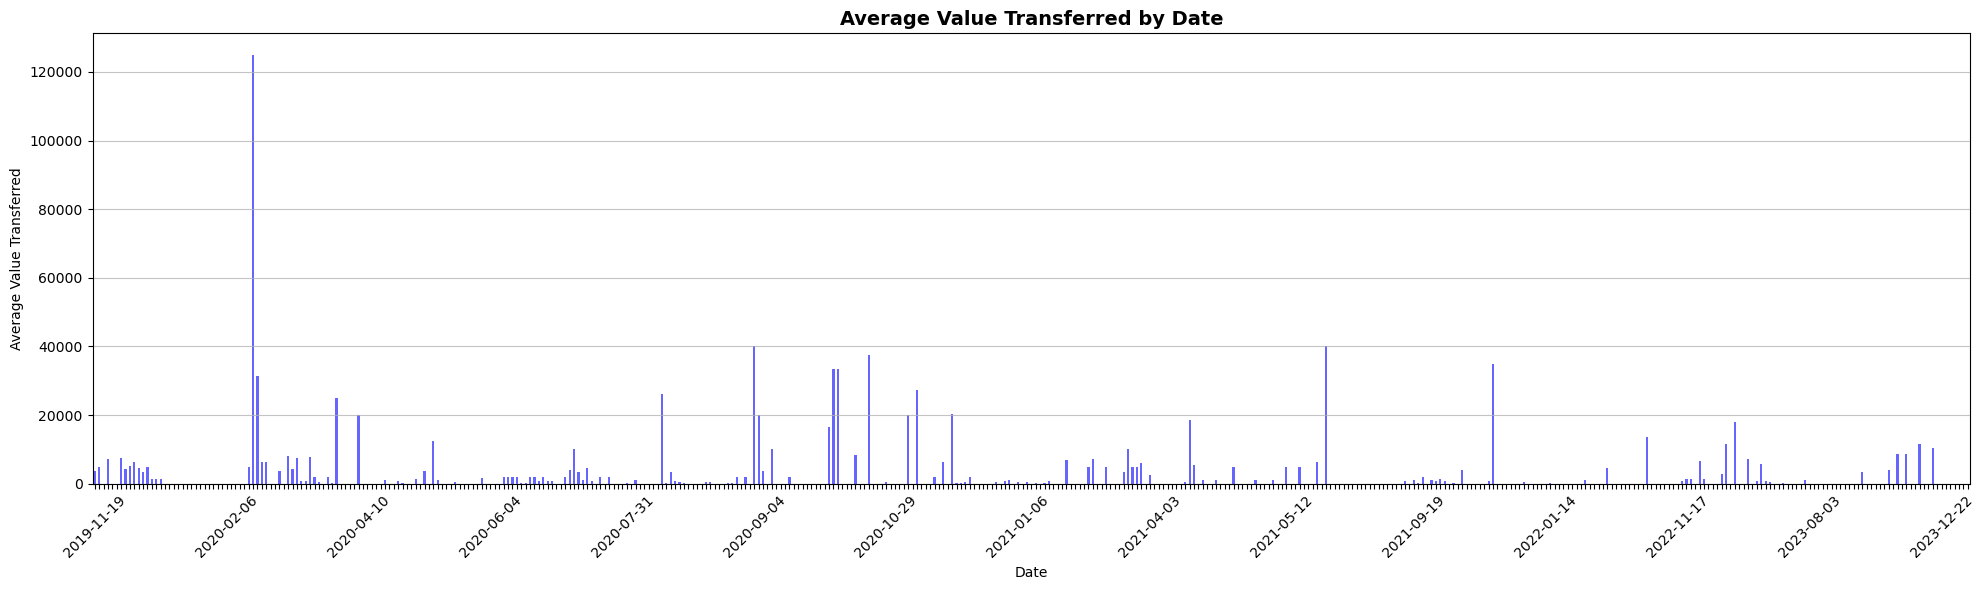

In [72]:
# Convert timeStamp to datetime and extract date and month
df_normal['timeStamp'] = pd.to_datetime(df_normal['timeStamp'])
df_normal['date'] = df_normal['timeStamp'].dt.date
df_normal['month'] = df_internal['timeStamp'].dt.to_period('M')

# 1. Number of unique transactions by date/month
transactions_by_date = df_normal.groupby('date').nunique()['hash']
transactions_by_month = df_normal.groupby('month').nunique()['hash']

# 2. Average gas paid per transaction, and per transaction per month
df_normal['gas'] = pd.to_numeric(df_normal['gas'])
avg_gas_per_transaction = df_normal.groupby('hash')['gas'].mean()
avg_gas_per_transaction_per_month = df_normal.groupby('month')['gas'].mean()

# 3. Sum and average value transferred via internal transactions
df_normal['value'] = pd.to_numeric(df_normal['value'])
total_value_transferred_by_date = df_normal.groupby('date')['value'].sum()
average_value_transferred_by_date = df_normal.groupby('date')['value'].mean()

#unique transactions by date
plot_data(transactions_by_date, 'bar', 'Unique Transactions by Date', 'Date', 'Number of Transactions', 
          xticks_rotation=45, grid=True, xticks_reduction=30)

#unique transactions by month
plot_data(transactions_by_month, 'bar', 'Unique Transactions by Month', 'Month', 'Number of Transactions', 
          xticks_rotation=45, grid=True)

# Average gas paid per transaction, and per transaction per month
plot_data(avg_gas_per_transaction_per_month, 'bar', 'Average Gas per Transaction per Month', 'Month', 'Average Gas', 
          xticks_rotation=45, grid=True)

# Total value transferred
plot_data(total_value_transferred_by_date, 'bar', 'Total Value Transferred by Date', 'Date', 'Total Value Transferred', 
          xticks_rotation=45, grid=True, xticks_reduction=30)

# Average value transferred
plot_data(average_value_transferred_by_date, 'bar', 'Average Value Transferred by Date', 'Date', 'Average Value Transferred', 
          xticks_rotation=45, grid=True, xticks_reduction=30)

The highest number of unique transactions was recorded in February 2020. It's also evident that transaction activity in 2020 was more regular compared to subsequent years. Notably, the peak in transaction volume occurred in December 2023. This surge appears to be linked to the burning of Lido tokens and Ethereum-related developments. During this period, the account holder seemed to be focused on acquiring as many liquid assets as possible.

As for the average gas per transaction, it remained relatively stable, except for November 2019, which coincides with the creation of a key protocol, and for an unspecified reason in July 2022. The latter might be connected to broader market dynamics or specific activities undertaken by the account holder.

In [73]:
df_normal.to_csv('clean_normal_data.csv')

In [74]:
transfer_functions = ['transfer', 'swap', 'swapExactETHForTokens', 'swapTokensForExactETH', 
                      'swapExactTokensForTokens', 'swapTokensForExactTokens']

# Convert timeStamp to datetime
df_normal['timeStamp'] = pd.to_datetime(df_normal['timeStamp'])
df_normal['month'] = df_normal['timeStamp'].dt.to_period('M')

# 1. Most popular functions
popular_functions = df_normal['functionNameUpdated'].value_counts()

# 2. Function usage over time
function_usage_over_time = df_normal.groupby(['month', 'functionNameUpdated']).size().unstack(fill_value=0)

# 3. Sum of transferred token values
df_normal['value'] = pd.to_numeric(df_normal['value'], errors='coerce')
df_transfer = df_normal[df_normal['functionNameUpdated'].isin(transfer_functions)]
token_flow_transfers = df_transfer.groupby(['month', 'tokenName']).size().unstack(fill_value=0)

In [75]:
# Function for plotting data with additional formatting
def plot_data(data, kind, title, xlabel, ylabel, figsize=(20, 6), xticks_rotation=None, grid_axis=None, title_fontsize=14, stacked=False):
    ax = data.plot(kind=kind, figsize=figsize, title=title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xticks_rotation is not None:
        plt.xticks(rotation=xticks_rotation)
    if grid_axis:
        ax.grid(axis=grid_axis)
    ax.title.set_size(title_fontsize)
    ax.title.set_weight('bold')
    plt.show()

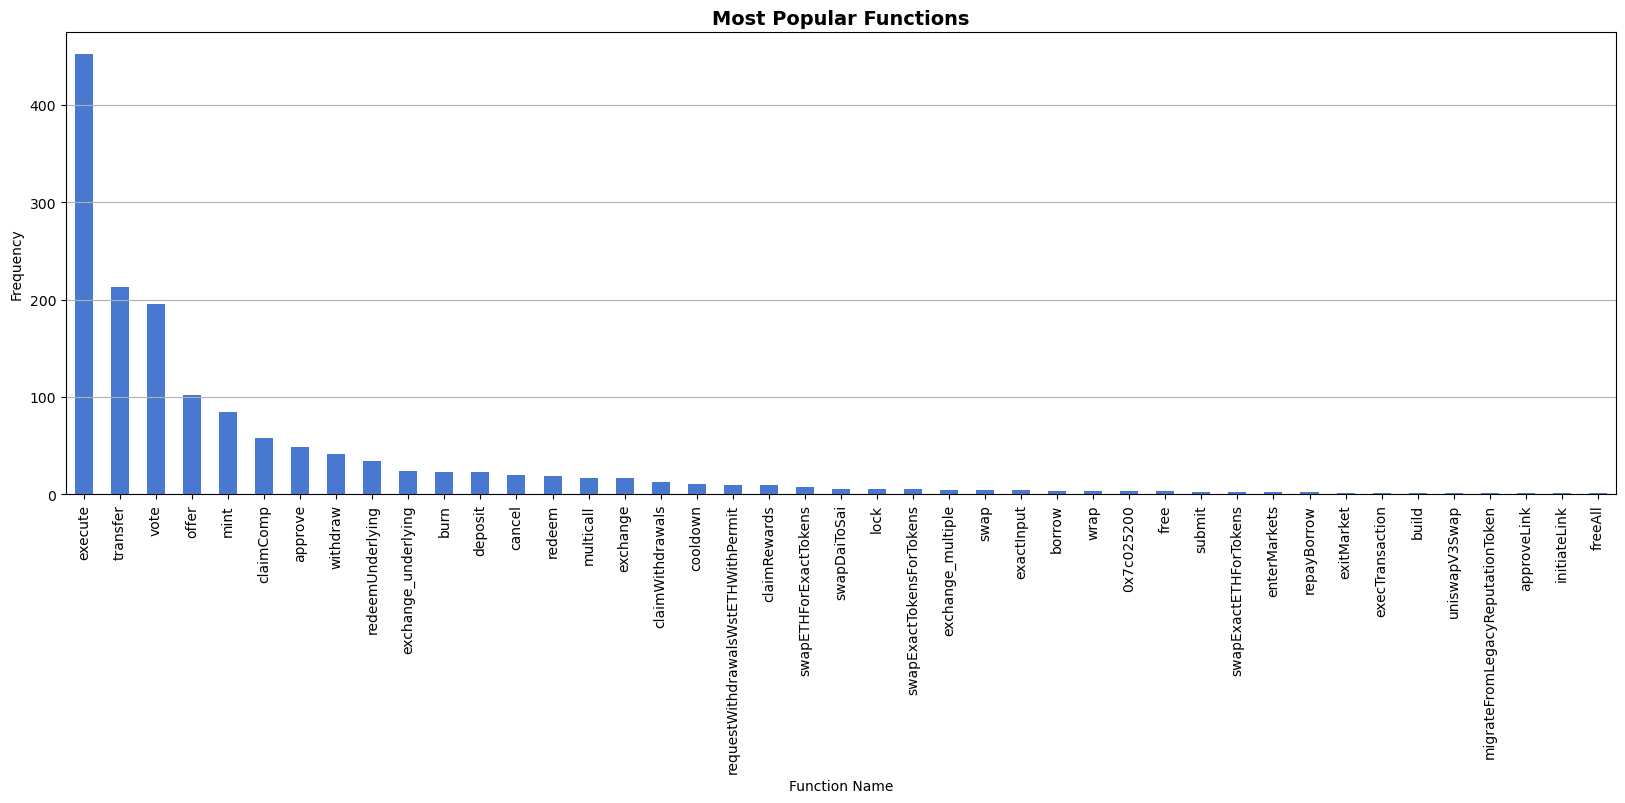

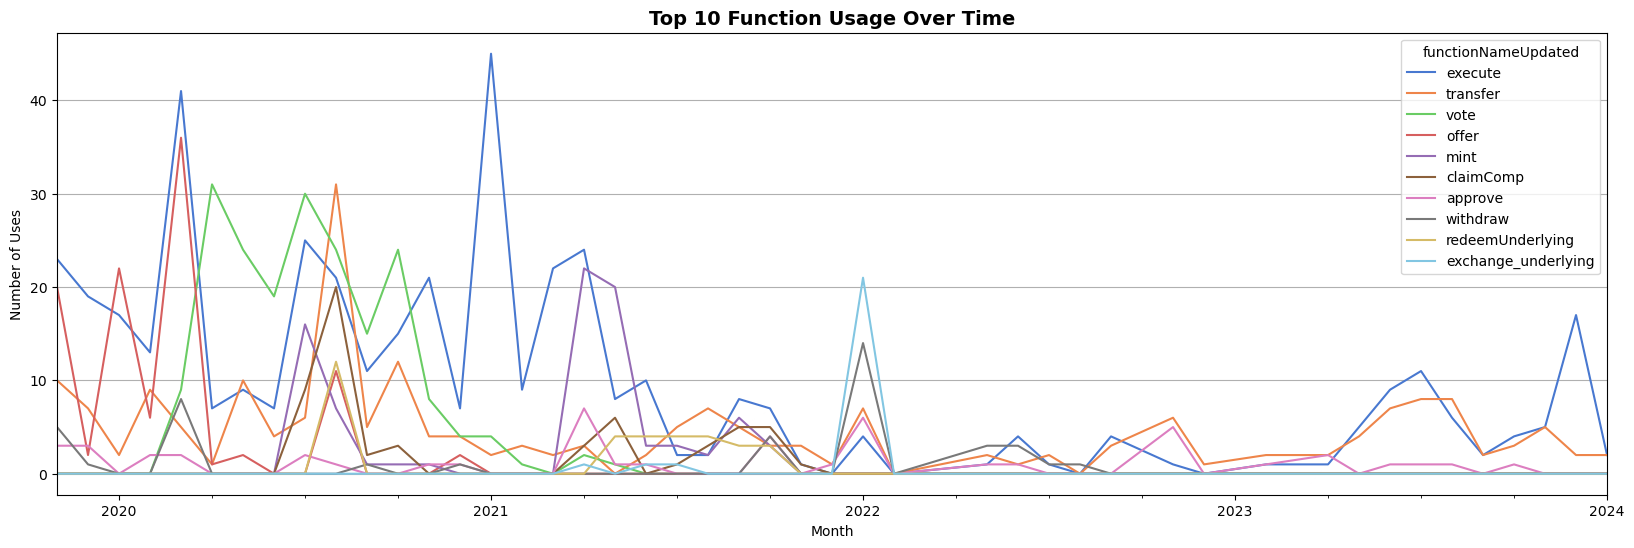

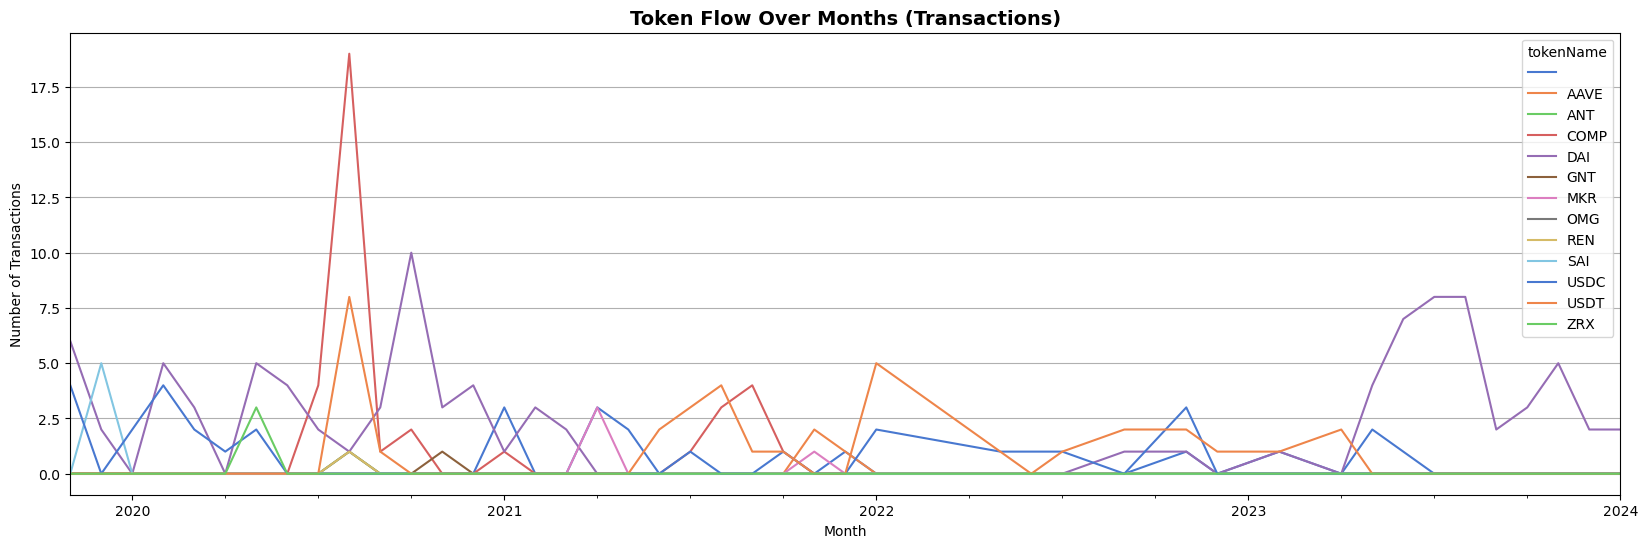

In [76]:
# Setting the color palette
sns.set_palette('muted')

# Popular Functions
plot_data(popular_functions, 'bar', 'Most Popular Functions', 'Function Name', 'Frequency', grid_axis='y')

# Top 10 most popular functions
top_10_functions = popular_functions.head(10)
top_10_function_usage = function_usage_over_time[top_10_functions.index]

# Top 10 Function Usage Over Time
plot_data(top_10_function_usage, 'line', 'Top 10 Function Usage Over Time', 'Month', 'Number of Uses', grid_axis='y')

# Token Flow (Number of Transactions)
plot_data(token_flow_transfers, 'line', 'Token Flow Over Months (Transactions)', 'Month', 'Number of Transactions', grid_axis='y')

# Token Flow (Transferred Values)
token_flow_values = df_transfer.groupby(['month', 'tokenName'])['value'].sum().unstack(fill_value=0)